# 1. Carga de datos
En esta sección se cargan todos los archivos necesarios para el análisis y construcción de los modelos de recomendación. Cada archivo contiene información relevante sobre juegos, usuarios, ratings, mecánicas, diseñadores, publishers, subcategorías, distribución de ratings y temas.

In [13]:
import pandas as pd

df_games = pd.read_csv("csv/games.csv")
df_designers_reduced = pd.read_csv("csv/designers_reduced.csv")
df_mechanics = pd.read_csv("csv/mechanics.csv")
df_publishers_reduced = pd.read_csv("csv/publishers_reduced.csv")
df_subcategories = pd.read_csv("csv/subcategories.csv")
df_ratings_distribution = pd.read_csv("csv/ratings_distribution.csv")
df_user_ratings = pd.read_csv("csv/user_ratings.csv")
df_artists_reduced = pd.read_csv("csv/artists_reduced.csv")
df_themes = pd.read_csv("csv/themes.csv")


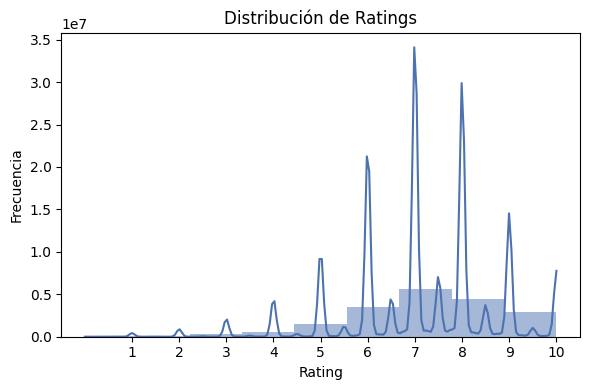

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import umap

os.makedirs("figs", exist_ok=True)

# 1) Distribución de ratings
plt.figure(figsize=(6, 4))
sns.histplot(
    df_user_ratings["Rating"],
    bins=9,
    kde=True,
    edgecolor=None,
    color="#4C72B0",
)
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.title("Distribución de Ratings")
plt.xticks(range(1, 11))
plt.tight_layout()
plt.savefig("figs/dataset_ratings_hist_kde.png", dpi=300)

# 2. Utilidades y funciones auxiliares
Se definen funciones y utilidades generales para el procesamiento de datos, manejo de splits y métricas.

In [ ]:
# === Imports y utils ===
import time, re, random, math
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import os
import json
from surprise import Dataset, Reader, NormalPredictor

def _fmt_secs(s):
    if s < 60: return f"{s:.1f}s"
    m, s = divmod(int(s), 60)
    if m < 60: return f"{m}m {s}s"
    h, m = divmod(m, 60); return f"{h}h {m}m"

def _eta(start_t, done, total):
    elapsed = time.time() - start_t
    if done == 0: return "?"
    rate = elapsed / done
    remain = rate * (total - done)
    return _fmt_secs(remain)

In [ ]:
def make_holdout_by_user(df_user_ratings, rating_scale=(1,10), test_frac=0.2, min_per_user=3, seed=42, log_every=10_000):
    from surprise import Dataset as SurpriseDataset, Reader

    rng = np.random.default_rng(seed)
    df = df_user_ratings.copy()
    df["Username"] = df["Username"].astype(str)
    df["BGGId"] = df["BGGId"].astype(str)

    counts = df.groupby("Username")["BGGId"].count()
    keep_users = counts[counts >= min_per_user].index
    df = df[df["Username"].isin(keep_users)].reset_index(drop=True)

    train_rows, test_rows = [], []
    user_groups = df.groupby("Username", sort=False)
    total_users = len(user_groups)
    print(f"[Split] Usuarios a procesar: {total_users:,}")
    t0 = time.time()

    for idx, (uid, g) in enumerate(user_groups, 1):
        idxs = rng.permutation(len(g))
        n_test = max(1, int(round(test_frac * len(g))))
        test_idx = set(idxs[:n_test])

        for i, row in enumerate(g.itertuples(index=False)):
            (test_rows if i in test_idx else train_rows).append(row)

        if idx % log_every == 0:
            elapsed = time.time() - t0
            print(f"[Split] {idx:,}/{total_users:,} usuarios ({idx/total_users:>.1%}) | "
                  f"elapsed {_fmt_secs(elapsed)} | ETA {_eta(t0, idx, total_users)}")

    train_df = pd.DataFrame(train_rows, columns=df.columns)
    test_df  = pd.DataFrame(test_rows,  columns=df.columns)

    data = SurpriseDataset.load_from_df(
        train_df[["Username","BGGId","Rating"]],
        Reader(rating_scale=rating_scale)
    )
    trainset = data.build_full_trainset()

    testset = list(test_df[["Username","BGGId","Rating"]].itertuples(index=False, name=None))

    print(f"[Split] Usuarios: {trainset.n_users:,} | Ítems: {trainset.n_items:,} | "
          f"Train inter.: {trainset.n_ratings:,} | Test inter.: {len(testset):,}")
    print(f"[Split] Hecho en {_fmt_secs(time.time()-t0)}")

    return trainset, testset, train_df, test_df

In [5]:
# === Candidatos por usuario ===
def build_eval_candidates(trainset, testset, n_neg=100, seed=42, log_every=10_000):
    print("[Candidates] Construyendo candidatos...")
    t0 = time.time()
    random.seed(seed)

    heldout = defaultdict(list)
    for uid_raw, iid_raw, _ in testset:
        heldout[uid_raw].append(iid_raw)

    all_items_inner = set(trainset.all_items())
    seen_by_u = {u: set(j for (j, _) in trainset.ur[u]) for u in trainset.all_users()}

    cands = {}
    total_u = trainset.n_users
    for idx, u_inner in enumerate(trainset.all_users(), 1):
        uid_raw = trainset.to_raw_uid(u_inner)
        not_seen = list(all_items_inner - seen_by_u[u_inner])
        neg_sample = random.sample(not_seen, min(n_neg, len(not_seen)))
        cand = set(trainset.to_raw_iid(j) for j in neg_sample)
        for iid in heldout.get(uid_raw, []):
            cand.add(iid)
        cands[uid_raw] = cand

        if idx % log_every == 0:
            print(f"[Candidates] {idx:,}/{total_u:,} ({idx/total_u:>.1%}) | "
                  f"elapsed {_fmt_secs(time.time()-t0)} | ETA {_eta(t0, idx, total_u)}")

    print(f"[Candidates] Listo en {_fmt_secs(time.time()-t0)} "
          f"(usuarios={total_u:,}, items={trainset.n_items:,})")
    return cands, heldout

In [ ]:
def precision_recall_ndcg_map_mrr_at_k(
    topn,
    heldout,
    k=10,
    item_to_tags=None,
    item_popularity=None,
    total_interacciones_train=None,
    save_dir=None,
    save_name=None
):
    precisions, recalls, ndcgs, aps, rrs = [], [], [], [], []
    ilds, theme_concs, novelty_scores = [], [], []

    for uid, rel_items in heldout.items():
        rel = set(rel_items)
        recs = topn.get(uid, [])[:k]

        hits = [i for i, iid in enumerate(recs) if iid in rel]
        n_hits = len(hits)

        precisions.append(n_hits / k)
        recalls.append(n_hits / max(1, len(rel)))

        dcg = sum(1 / np.log2(i+2) for i in hits)
        idcg = sum(1 / np.log2(i+2) for i in range(min(len(rel), k)))
        ndcgs.append(dcg / idcg if idcg > 0 else 0)

        cum, ap = 0, 0
        for r, iid in enumerate(recs, start=1):
            if iid in rel:
                cum += 1
                ap += cum / r
        aps.append(ap / min(len(rel), k) if len(rel) else 0)

        first = min(hits) if hits else None
        rrs.append(1 / (first+1) if first is not None else 0)

        if item_to_tags:
            recs_k = [iid for iid in recs if iid in item_to_tags]
            if len(recs_k) > 1:
                tags = [set(item_to_tags[iid]) for iid in recs_k]
                sims = []
                for i in range(len(tags)):
                    for j in range(i+1, len(tags)):
                        u = tags[i] | tags[j]
                        inter = tags[i] & tags[j]
                        sims.append(len(inter) / len(u) if u else 0)
                if sims:
                    ilds.append(1 - np.mean(sims))

                prim = [next(iter(t)) if t else None for t in tags]
                cnt = Counter(prim)
                theme_concs.append(max(cnt.values()) / len(recs_k))

        if item_popularity and total_interacciones_train:
            for iid in recs:
                pop = item_popularity.get(iid, 1)
                p = pop / total_interacciones_train
                novelty_scores.append(-np.log2(p) if p > 0 else 0)

    metrics = {
        "Precision@K": float(np.mean(precisions)),
        "Recall@K": float(np.mean(recalls)),
        "nDCG@K": float(np.mean(ndcgs)),
        "MAP@K": float(np.mean(aps)),
        "MRR@K": float(np.mean(rrs)),
    }

    if ilds:
        metrics["IntraListDiversity@K"] = float(np.mean(ilds))
    if theme_concs:
        metrics["ThemeConcentration@K"] = float(np.mean(theme_concs))
    if novelty_scores:
        metrics["Novelty@K"] = float(np.mean(novelty_scores))

    if save_dir and save_name:
        os.makedirs(save_dir, exist_ok=True)
        path = os.path.join(save_dir, f"{save_name}.json")
        with open(path, "w", encoding="utf-8") as f:
            json.dump(metrics, f, indent=4)
        print(f"Métricas guardadas en {path}")

    return metrics

# 3. Modelos de recomendación
Implementación de modelos de recomendación.

## 3.0 Funciones de entrenamiento y ranking

### 3.0.1 BaseLines

In [7]:
# === Baseline: Most Popular ===
def most_popular_sorted(trainset, log_every=2_000_000):
    print("[MostPopular] Contando interacciones en train...")
    t0 = time.time()
    cnt = Counter()
    total = trainset.n_ratings
    done = 0
    for (u, i, _) in trainset.all_ratings():
        cnt[trainset.to_raw_iid(i)] += 1
        done += 1
        if done % log_every == 0:
            print(f"[MostPopular] {done:,}/{total:,} ({done/total:>.1%}) | ETA {_eta(t0, done, total)}")
    popular = [iid for iid,_ in cnt.most_common()]
    print(f"[MostPopular] Hecho en {_fmt_secs(time.time()-t0)}.")
    return popular

def topn_popular_from_candidates(popular_sorted, cands_by_u, n=10, log_every=10000):
    print("[MostPopular] Generando Top-N...")
    t0 = time.time()
    topn = {}
    users = list(cands_by_u.keys())
    total = len(users)
    for idx, uid in enumerate(users, 1):
        cand = cands_by_u[uid]
        ordered = [iid for iid in popular_sorted if iid in cand]
        topn[uid] = ordered[:n]
        if idx % log_every == 0:
            print(f"[MostPopular] {idx:,}/{total:,} ({idx/total:>.1%}) | ETA {_eta(t0, idx, total)}")
    print(f"[MostPopular] Listo en {_fmt_secs(time.time()-t0)}.")
    return topn

# === Baseline: Random ===
def topn_from_predictions(predictions, n=10):
    topn = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        topn[uid].append((iid, est))
    for uid, lst in topn.items():
        lst.sort(key=lambda x: x[1], reverse=True)
        topn[uid] = [iid for iid,_ in lst[:n]]
    return topn

def random_topn(trainset, candidates_by_user, n=10, log_every=10000):
    print("[Random] Entrenando NormalPredictor...")
    t0 = time.time()
    algo = NormalPredictor().fit(trainset)
    print(f"[Random] Entrenamiento: {_fmt_secs(time.time()-t0)}")

    print("[Random] Prediciendo...")
    t1 = time.time()
    preds = []
    users = list(candidates_by_user.keys())
    total_u = len(users)
    for ui, uid in enumerate(users, 1):
        items = candidates_by_user[uid]
        preds.extend([algo.predict(uid, iid) for iid in items])
        if ui % log_every == 0:
            print(f"[Random] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t1, ui, total_u)}")
    print(f"[Random] Predicción: {_fmt_secs(time.time()-t1)}")

    print("[Random] Top-N...")
    t2 = time.time()
    out = topn_from_predictions(preds, n=n)
    print(f"[Random] Top-N: {_fmt_secs(time.time()-t2)}")
    return out

# === Baseline: Content-Based ===
from sklearn.feature_extraction.text import TfidfVectorizer

def build_cb_index(df_games, df_themes=None, max_features=60000):
    print("[CB] Preparando index...")
    t0 = time.time()
    games = df_games.copy()
    games["BGGId"] = games["BGGId"].astype(str)

    cat_cols = [c for c in games.columns if c.startswith("Cat:")]
    def cat_tokens(row):
        toks=[]
        for c in cat_cols:
            try:
                if int(row[c])==1:
                    toks.append("cat_"+c.split(":",1)[1].lower())
            except: pass
        return " ".join(toks)

    gamesX = games[["BGGId","Name","Description"]].copy()
    gamesX["cat_tok"] = games.apply(cat_tokens, axis=1).fillna("")

    if df_themes is not None:
        th = df_themes.copy()
        th["BGGId"] = th["BGGId"].astype(str)
        tcols = [c for c in th.columns if c!="BGGId"]
        def norm(s): 
            s = s.lower(); s = re.sub(r"[^a-z0-9]+","_",s); return re.sub(r"_+","_",s).strip("_")
        def th_tokens(row):
            toks=[]
            for c in tcols:
                try:
                    if int(row[c])==1:
                        toks.append("theme_"+norm(c))
                except: pass
            return " ".join(toks)
        themes_tok = th[["BGGId"]].copy()
        themes_tok["theme_tok"] = th.apply(th_tokens, axis=1)
        gamesX = gamesX.merge(themes_tok, on="BGGId", how="left")
        gamesX["theme_tok"] = gamesX["theme_tok"].fillna("")
    else:
        gamesX["theme_tok"] = ""

    for col in ["Description","cat_tok","theme_tok"]:
        gamesX[col] = gamesX[col].fillna("")
    gamesX["desc_plus"] = (gamesX["Description"]+" "+gamesX["cat_tok"]+" "+gamesX["theme_tok"]).str.strip()

    vec = TfidfVectorizer(max_features=max_features, ngram_range=(1,2), stop_words="english")
    X = vec.fit_transform(gamesX["desc_plus"])

    iid2row = {iid:i for i,iid in enumerate(gamesX["BGGId"].tolist())}
    row2iid = {i:iid for iid,i in iid2row.items()}
    print(f"[CB] Index listo en {_fmt_secs(time.time()-t0)} | X={X.shape}")
    return {"vec":vec,"X":X,"iid2row":iid2row,"row2iid":row2iid,"gamesX":gamesX}

def cb_topn_from_candidates(trainset, cands_by_u, cb_index, fallback_pop=None, n=10, log_every=10000):
    print("[CB] Top-N por similitud...")
    t0 = time.time()
    X = cb_index["X"]; iid2row = cb_index["iid2row"]; row2iid = cb_index["row2iid"]
    topn = {}
    total_u = trainset.n_users
    for idx, u_inner in enumerate(trainset.all_users(), 1):
        uid = trainset.to_raw_uid(u_inner)
        items = [j for (j,_) in trainset.ur[u_inner]]
        rows = [iid2row.get(trainset.to_raw_iid(j)) for j in items]
        rows = [r for r in rows if r is not None]
        if not rows:
            if fallback_pop is not None:
                cand = cands_by_u.get(uid, set())
                topn[uid] = [iid for iid in fallback_pop if iid in cand][:n]
            else:
                topn[uid] = []
        else:
            prof = X[rows].mean(axis=0)
            cand = cands_by_u.get(uid, set())
            cand_rows = [iid2row[iid] for iid in cand if iid in iid2row]
            if not cand_rows:
                topn[uid] = []
            else:
                scores = (X[cand_rows] @ prof.T).A.ravel()
                order = np.argsort(-scores)[:n]
                topn[uid] = [row2iid[cand_rows[i]] for i in order]

        if idx % log_every == 0:
            print(f"[CB] {idx:,}/{total_u:,} ({idx/total_u:>.1%}) | ETA {_eta(t0, idx, total_u)}")
    print(f"[CB] Listo en {_fmt_secs(time.time()-t0)}.")
    return topn


### 3.0.2 Propuestas

In [8]:
# === iKNN ===
from surprise import KNNBasic

def iknn_topn(trainset, cands_by_u, n=10, sim_name='pearson', user_based=False, log_every=10000):
    print("[iKNN] Entrenando item-based KNN...")
    t0 = time.time()
    sim_options = {'name': sim_name, 'user_based': user_based}
    algo = KNNBasic(sim_options=sim_options).fit(trainset)
    print(f"[iKNN] Entrenamiento: {_fmt_secs(time.time()-t0)}")

    print("[iKNN] Prediciendo...")
    t1 = time.time()
    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)
    for ui, uid in enumerate(users, 1):
        items = cands_by_u[uid]
        preds.extend([algo.predict(uid, iid) for iid in items])
        if ui % log_every == 0:
            print(f"[iKNN] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t1, ui, total_u)}")
    print(f"[iKNN] Predicción: {_fmt_secs(time.time()-t1)}")

    print("[iKNN] Top-N...")
    t2 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[iKNN] Top-N: {_fmt_secs(time.time()-t2)}")
    return topn

# === SVD ===
from surprise import SVD

def svd_topn(trainset, cands_by_u, n=10, n_factors=50, n_epochs=20, random_state=42, log_every=10000):
    print("[SVD] Entrenando SVD...")
    t0 = time.time()
    algo = SVD(n_factors=n_factors, n_epochs=n_epochs, random_state=random_state).fit(trainset)
    print(f"[SVD] Entrenamiento: {_fmt_secs(time.time()-t0)}")

    print("[SVD] Prediciendo...")
    t1 = time.time()
    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)
    for ui, uid in enumerate(users, 1):
        items = cands_by_u[uid]
        preds.extend([algo.predict(uid, iid) for iid in items])
        if ui % log_every == 0:
            print(f"[SVD] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t1, ui, total_u)}")
    print(f"[SVD] Predicción: {_fmt_secs(time.time()-t1)}")

    print("[SVD] Top-N...")
    t2 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[SVD] Top-N: {_fmt_secs(time.time()-t2)}")
    return topn

# === Híbrido: SVD + Popularidad ===
def _popularity_scores(trainset, pow_alpha=1.0, log_every=2_000_000):
    print("[Hybrid] Calculando popularidad...")
    t0 = time.time()
    cnt = Counter()
    total = trainset.n_ratings
    done = 0
    for (_, i, _) in trainset.all_ratings():
        cnt[trainset.to_raw_iid(i)] += 1
        done += 1
        if done % log_every == 0:
            print(f"[Hybrid] {done:,}/{total:,} ({done/total:>.1%}) | ETA {_eta(t0, done, total)}")

    if not cnt:
        return {}

    vals = np.array(list(cnt.values()), dtype=float)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        base = {iid: 0.5 for iid in cnt.keys()}
    else:
        base = {iid: (c - vmin) / (vmax - vmin) for iid, c in cnt.items()}

    if pow_alpha != 1.0:
        base = {iid: (s ** pow_alpha) for iid, s in base.items()}

    return base


def svd_pop_blend_topn(
    trainset,
    cands_by_u,
    n=10,
    n_factors=50,
    n_epochs=20,
    random_state=42,
    weight_pop=0.4,
    pop_pow=1.0,
    rating_scale=(1,10),
    log_every=10_000,
):
    w = float(weight_pop)
    assert 0.0 <= w <= 1.0, "weight_pop debe estar en [0,1]"
    rmin, rmax = rating_scale
    span = (rmax - rmin)

    # 1) Entrena SVD
    print("[Hybrid] Entrenando SVD...")
    t0 = time.time()
    svd = SVD(n_factors=n_factors, n_epochs=n_epochs, random_state=random_state).fit(trainset)
    print(f"[Hybrid] SVD entrenado en {_fmt_secs(time.time()-t0)}")

    # 2) Popularidad normalizada
    pop_scores = _popularity_scores(trainset, pow_alpha=pop_pow)

    # 3) Predicciones combinadas
    print("[Hybrid] Prediciendo y combinando...")
    t1 = time.time()
    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)

    for ui, uid in enumerate(users, 1):
        for iid in cands_by_u[uid]:
            est_svd = svd.predict(uid, iid).est
            pop_raw = pop_scores.get(iid, 0.0)
            pop_scaled = rmin + pop_raw * span
            blended = (1.0 - w) * est_svd + w * pop_scaled
            preds.append((uid, iid, None, blended, {"svd": est_svd, "pop": pop_raw}))

        if ui % log_every == 0:
            print(f"[Hybrid] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t1, ui, total_u)}")

    print(f"[Hybrid] Predicción combinada: {_fmt_secs(time.time()-t1)}")

    # 4) Top-N
    print("[Hybrid] Top-N...")
    t2 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[Hybrid] Top-N: {_fmt_secs(time.time()-t2)}")
    return topn


In [35]:
# === DeepFM ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------- Mappings desde dataframes ----------
def build_id_mappings_from_traindf(train_df, user_col="Username", item_col="BGGId"):
    df_clean = train_df[[user_col, item_col]].copy()
    df_clean[user_col] = df_clean[user_col].astype(str)
    df_clean[item_col] = df_clean[item_col].astype(str)

    # quitamos NaN y "nan" string
    mask_valid = (
        df_clean[user_col].notna() &
        (df_clean[user_col] != "nan") &
        df_clean[item_col].notna() &
        (df_clean[item_col] != "nan")
    )
    df_clean = df_clean[mask_valid]

    uvals = df_clean[user_col].unique().tolist()
    ivals = df_clean[item_col].unique().tolist()

    uid2idx = {u:i for i,u in enumerate(uvals)}
    iid2idx = {i:j for j,i in enumerate(ivals)}
    idx2uid = {i:u for u,i in uid2idx.items()}
    idx2iid = {j:i for i,j in iid2idx.items()}
    return uid2idx, iid2idx, idx2uid, idx2iid

# ---------- Dataset ----------
class DeepFMDataset(Dataset):
    def __init__(self, df, uid2idx, iid2idx, rating_col="Rating", user_col="Username", item_col="BGGId"):
        s_u = df[user_col].astype(str).map(uid2idx)
        s_i = df[item_col].astype(str).map(iid2idx)

        mask = s_u.notna() & s_i.notna()
        s_u = s_u[mask].astype(np.int64)
        s_i = s_i[mask].astype(np.int64)
        y = df.loc[mask, rating_col].values.astype(np.float32)

        self.u = s_u.values
        self.i = s_i.values
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.u[idx], self.i[idx], self.y[idx])

# ---------- Módulo DeepFM ----------
class DeepFM(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, mlp_layers=(128, 64), dropout=0.2, rating_scale=(1,10)):
        super().__init__()
        self.rmin, self.rmax = rating_scale
        self.span = self.rmax - self.rmin

        # Embeddings
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)

        # First-order
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))

        # Deep
        deep_in = emb_dim * 2
        layers = []
        prev = deep_in
        for h in mlp_layers:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.deep = nn.Sequential(*layers)

        self._init_params()

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def fm_bi_interaction(self, feat_embs):
        # feat_embs: [B, F, D]
        sum_ = feat_embs.sum(dim=1)
        sum_sq = sum_ * sum_
        sq_sum = (feat_embs * feat_embs).sum(1)
        bi = 0.5 * (sum_sq - sq_sum)
        return bi.sum(dim=1, keepdim=True)

    def forward(self, u, i):
        ue = self.user_emb(u)
        ie = self.item_emb(i)

        # First-order
        lin = self.global_bias + self.user_bias(u) + self.item_bias(i)

        # FM second-order
        feats = torch.stack([ue, ie], dim=1)
        fm = self.fm_bi_interaction(feats)

        # Deep
        deep_in = torch.cat([ue, ie], dim=1)
        deep_out = self.deep(deep_in)

        y = lin + fm + deep_out
        y = torch.sigmoid(y) * self.span + self.rmin
        return y.squeeze(1)

# ---------- Entrenamiento ----------
def train_deepfm(
    train_df,
    rating_scale=(1,10),
    user_col="Username",
    item_col="BGGId",
    rating_col="Rating",
    emb_dim=32,
    mlp_layers=(128,64),
    dropout=0.2,
    lr=2e-3,
    weight_decay=1e-6,
    batch_size=2048,
    epochs=8,
    seed=42,
    device=None,
    log_every=200
):
    print("[DeepFM] Preparando datos y modelo...")
    t0 = time.time()
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    uid2idx, iid2idx, idx2uid, idx2iid = build_id_mappings_from_traindf(train_df, user_col, item_col)
    ds = DeepFMDataset(train_df, uid2idx, iid2idx, rating_col, user_col, item_col)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model = DeepFM(
        n_users=len(uid2idx),
        n_items=len(iid2idx),
        emb_dim=emb_dim,
        mlp_layers=mlp_layers,
        dropout=dropout,
        rating_scale=rating_scale
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    print(f"[DeepFM] Entrenando en {device} (epochs={epochs}, bs={batch_size})")
    step = 0
    for ep in range(1, epochs+1):
        ep_loss, n = 0.0, 0
        ep_t0 = time.time()
        for (u,i,y) in dl:
            u = u.to(device); i = i.to(device); y = y.to(device)
            opt.zero_grad()
            pred = model(u,i)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            ep_loss += loss.item() * y.size(0)
            n += y.size(0)
            step += 1
            if step % log_every == 0:
                print(f"[DeepFM][ep{ep}] step={step:,} | loss={loss.item():.4f}")
        print(f"[DeepFM] Epoch {ep}/{epochs} | loss={ep_loss/n:.4f} | tiempo={_fmt_secs(time.time()-ep_t0)}")

    print(f"[DeepFM] Listo en {_fmt_secs(time.time()-t0)}")
    state = {
        "model": model,
        "uid2idx": uid2idx, "iid2idx": iid2idx,
        "idx2uid": idx2uid, "idx2iid": idx2iid,
        "device": device,
        "rating_scale": rating_scale
    }
    return state

# ---------- Predicción sobre candidatos y Top-N ----------
@torch.no_grad()
def deepfm_topn_from_candidates(state, cands_by_u, n=10, log_every=10_000):
    print("[DeepFM] Prediciendo sobre candidatos...")
    t0 = time.time()
    model = state["model"]; model.eval()
    uid2idx = state["uid2idx"]; iid2idx = state["iid2idx"]; device = state["device"]

    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)

    # Batching manual sobre (uid,iid)
    batch_u, batch_i, batch_uid, batch_iid = [], [], [], []
    def flush():
        nonlocal preds, batch_u, batch_i, batch_uid, batch_iid
        if not batch_u: return
        u = torch.tensor(batch_u, dtype=torch.long, device=device)
        i = torch.tensor(batch_i, dtype=torch.long, device=device)
        est = model(u,i).detach().cpu().numpy().tolist()
        for _uid, _iid, _est in zip(batch_uid, batch_iid, est):
            preds.append((_uid, _iid, None, float(_est), {}))
        batch_u.clear(); batch_i.clear(); batch_uid.clear(); batch_iid.clear()

    for ui, uid in enumerate(users, 1):
        uidx = uid2idx.get(str(uid), None)
        if uidx is None:
            # usuario frío -> saltar o asignar nada
            if ui % log_every == 0:
                print(f"[DeepFM] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t0, ui, total_u)}")
            continue
        for iid in cands_by_u[uid]:
            iidx = iid2idx.get(str(iid), None)
            if iidx is None:
                # ítem frío (no visto en train) -> omitir
                continue
            batch_u.append(uidx); batch_i.append(iidx)
            batch_uid.append(uid); batch_iid.append(iid)
            if len(batch_u) >= 65_536:
                flush()
        if ui % log_every == 0:
            print(f"[DeepFM] {ui:,}/{total_u:,} ({ui/total_u:>.1%}) | ETA {_eta(t0, ui, total_u)}")
    flush()

    print(f"[DeepFM] Predicción: {_fmt_secs(time.time()-t0)}")

    print("[DeepFM] Top-N...")
    t1 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[DeepFM] Top-N: {_fmt_secs(time.time()-t1)}")
    return topn


## 3.1 Split de entrenamiento y prueba
Se realiza la separación de los datos de usuario en conjuntos de entrenamiento y prueba para evaluar los modelos de recomendación de manera justa y reproducible.

### 3.1.0 Split

In [16]:
# 1) Split sin subset
trainset, testset, train_df, test_df = make_holdout_by_user(
    df_user_ratings, rating_scale=(1,10), test_frac=0.2, min_per_user=3, seed=42
)

# 2) Split con subset
# subset = df_user_ratings.sample(frac=0.05, random_state=42)
# trainset, testset, train_df, test_df = make_holdout_by_user(
#     subset, rating_scale=(1,10), test_frac=0.2, min_per_user=3, seed=42
# )

[Split] Usuarios a procesar: 304,607
[Split] 10,000/304,607 usuarios (3.3%) | elapsed 5.6s | ETA 2m 44s
[Split] 10,000/304,607 usuarios (3.3%) | elapsed 5.6s | ETA 2m 44s
[Split] 20,000/304,607 usuarios (6.6%) | elapsed 8.5s | ETA 2m 0s
[Split] 20,000/304,607 usuarios (6.6%) | elapsed 8.5s | ETA 2m 0s
[Split] 30,000/304,607 usuarios (9.8%) | elapsed 11.0s | ETA 1m 40s
[Split] 30,000/304,607 usuarios (9.8%) | elapsed 11.0s | ETA 1m 40s
[Split] 40,000/304,607 usuarios (13.1%) | elapsed 13.2s | ETA 1m 27s
[Split] 40,000/304,607 usuarios (13.1%) | elapsed 13.2s | ETA 1m 27s
[Split] 50,000/304,607 usuarios (16.4%) | elapsed 15.3s | ETA 1m 17s
[Split] 50,000/304,607 usuarios (16.4%) | elapsed 15.3s | ETA 1m 17s
[Split] 60,000/304,607 usuarios (19.7%) | elapsed 2m 3s | ETA 8m 24s
[Split] 60,000/304,607 usuarios (19.7%) | elapsed 2m 3s | ETA 8m 24s
[Split] 70,000/304,607 usuarios (23.0%) | elapsed 2m 6s | ETA 7m 4s
[Split] 70,000/304,607 usuarios (23.0%) | elapsed 2m 6s | ETA 7m 4s
[Split] 80,

In [18]:
# 1) Alinear tipos de ID entre ratings y catálogo de juegos
train_df["BGGId"] = train_df["BGGId"].astype(str)
df_games["BGGId"] = df_games["BGGId"].astype(str)

# 2) Popularidad por juego en el TRAIN
item_popularity = (
    train_df
    .groupby("BGGId")
    .size()
    .to_dict()
)

total_interacciones_train = float(sum(item_popularity.values()))

# 3) Categorías por juego usando columnas Cat:...
cat_cols = [c for c in df_games.columns if c.startswith("Cat:")]

def row_to_tags(row):
    tags = []
    for col in cat_cols:
        if bool(row[col]):
            tags.append(col.replace("Cat:", ""))
    return tags

df_games["tags_list"] = df_games.apply(row_to_tags, axis=1)

item_to_tags = (
    df_games
    .set_index("BGGId")["tags_list"]
    .to_dict()
)

### 3.1.1 Graficos Representativos de Train y Test

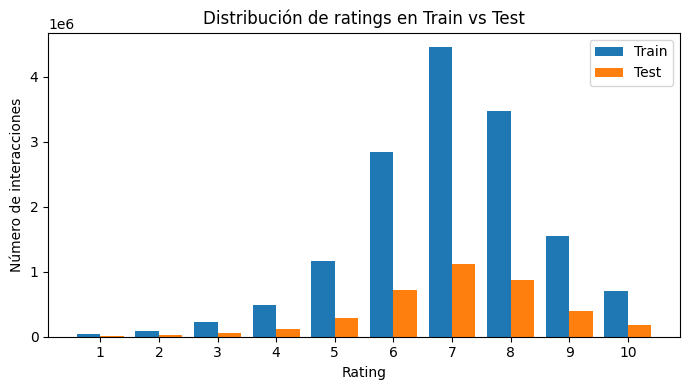

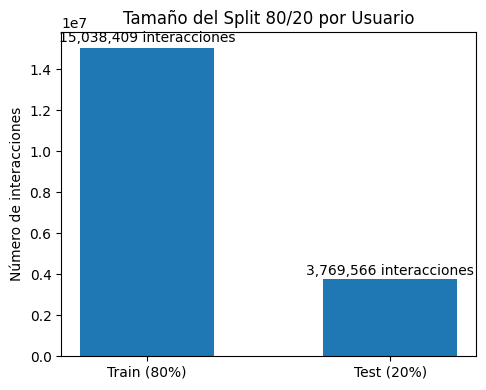

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("figs", exist_ok=True)

train_ratings = train_df["Rating"].dropna().astype(int)
test_ratings = test_df["Rating"].dropna().astype(int)
ratings = np.arange(1, 11)

train_counts = train_ratings.value_counts().reindex(ratings, fill_value=0)
test_counts  = test_ratings.value_counts().reindex(ratings, fill_value=0)

x = np.arange(len(ratings))
width = 0.4

plt.figure(figsize=(7, 4))

plt.bar(x - width/2, train_counts.values, width=width, label="Train")
plt.bar(x + width/2, test_counts.values, width=width, label="Test")

plt.xticks(x, ratings)
plt.xlabel("Rating")
plt.ylabel("Número de interacciones")
plt.title("Distribución de ratings en Train vs Test")
plt.legend()
plt.tight_layout()

plt.savefig("figs/distribucion_ratings_train_test_barras.png", dpi=300, bbox_inches="tight")

n_train = len(train_df)
n_test = len(test_df)

plt.figure(figsize=(5, 4))

bars = plt.bar(
    ["Train (80%)", "Test (20%)"],
    [n_train, n_test],
    width=0.55
)

for bar, value in zip(bars, [n_train, n_test]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + (0.01 * bar.get_height()),
        f"{value:,} interacciones",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("Tamaño del Split 80/20 por Usuario", fontsize=12)
plt.ylabel("Número de interacciones")
plt.tight_layout()

plt.savefig("figs/protocolo_split_holdout.png", dpi=300, bbox_inches="tight")

## 3.2 Generación de candidatos
Se generan los ítems candidatos para cada usuario, mezclando negativos y positivos reales, para simular el proceso de recomendación y evaluación.

In [20]:
# 2) Candidatos
cands, heldout = build_eval_candidates(trainset, testset, n_neg=100, seed=42)
popular_sorted = most_popular_sorted(trainset)

[Candidates] Construyendo candidatos...
[Candidates] 10,000/304,607 (3.3%) | elapsed 9.0s | ETA 4m 24s
[Candidates] 10,000/304,607 (3.3%) | elapsed 9.0s | ETA 4m 24s
[Candidates] 20,000/304,607 (6.6%) | elapsed 14.7s | ETA 3m 28s
[Candidates] 20,000/304,607 (6.6%) | elapsed 14.7s | ETA 3m 28s
[Candidates] 30,000/304,607 (9.8%) | elapsed 20.6s | ETA 3m 8s
[Candidates] 30,000/304,607 (9.8%) | elapsed 20.6s | ETA 3m 8s
[Candidates] 40,000/304,607 (13.1%) | elapsed 26.5s | ETA 2m 55s
[Candidates] 40,000/304,607 (13.1%) | elapsed 26.5s | ETA 2m 55s
[Candidates] 50,000/304,607 (16.4%) | elapsed 32.4s | ETA 2m 45s
[Candidates] 50,000/304,607 (16.4%) | elapsed 32.4s | ETA 2m 45s
[Candidates] 60,000/304,607 (19.7%) | elapsed 38.2s | ETA 2m 35s
[Candidates] 60,000/304,607 (19.7%) | elapsed 38.2s | ETA 2m 35s
[Candidates] 70,000/304,607 (23.0%) | elapsed 44.1s | ETA 2m 27s
[Candidates] 70,000/304,607 (23.0%) | elapsed 44.1s | ETA 2m 27s
[Candidates] 80,000/304,607 (26.3%) | elapsed 49.8s | ETA 2m

## 3.3 Aplicación de Modelos

### 3.3.1 Modelo Most Popular
Se implementa el modelo de popularidad, que recomienda los ítems más populares (con más interacciones) a cada usuario.

In [21]:
# 1) Most Popular
topn_pop = topn_popular_from_candidates(popular_sorted, cands, n=10)

[MostPopular] Generando Top-N...
[MostPopular] 10,000/304,607 (3.3%) | ETA 2m 50s
[MostPopular] 10,000/304,607 (3.3%) | ETA 2m 50s
[MostPopular] 20,000/304,607 (6.6%) | ETA 2m 42s
[MostPopular] 20,000/304,607 (6.6%) | ETA 2m 42s
[MostPopular] 30,000/304,607 (9.8%) | ETA 2m 35s
[MostPopular] 30,000/304,607 (9.8%) | ETA 2m 35s
[MostPopular] 40,000/304,607 (13.1%) | ETA 2m 26s
[MostPopular] 40,000/304,607 (13.1%) | ETA 2m 26s
[MostPopular] 50,000/304,607 (16.4%) | ETA 2m 16s
[MostPopular] 50,000/304,607 (16.4%) | ETA 2m 16s
[MostPopular] 60,000/304,607 (19.7%) | ETA 2m 8s
[MostPopular] 60,000/304,607 (19.7%) | ETA 2m 8s
[MostPopular] 70,000/304,607 (23.0%) | ETA 2m 0s
[MostPopular] 70,000/304,607 (23.0%) | ETA 2m 0s
[MostPopular] 80,000/304,607 (26.3%) | ETA 1m 54s
[MostPopular] 80,000/304,607 (26.3%) | ETA 1m 54s
[MostPopular] 90,000/304,607 (29.5%) | ETA 1m 47s
[MostPopular] 90,000/304,607 (29.5%) | ETA 1m 47s
[MostPopular] 100,000/304,607 (32.8%) | ETA 1m 41s
[MostPopular] 100,000/304,

In [22]:
metrics_pop = precision_recall_ndcg_map_mrr_at_k(
    topn_pop, 
    heldout, 
    k=10, 
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="popularity_model")
metrics_pop

Métricas guardadas en metrics\popularity_model.json


{'Precision@K': 0.4458026243651656,
 'Recall@K': 0.6647057297007513,
 'nDCG@K': 0.7451624136276042,
 'MAP@K': 0.6569179273380309,
 'MRR@K': 0.8163909523074777,
 'IntraListDiversity@K': 0.7278534064962151,
 'ThemeConcentration@K': 0.4388743528546619,
 'Novelty@K': 10.791717914569169}

### 3.3.2 Modelo Random
Se implementa un modelo aleatorio (NormalPredictor) que recomienda ítems al azar, sirviendo como baseline inferior para comparar el desempeño de otros modelos.

In [23]:
# 2) Random
topn_rand = random_topn(trainset, cands, n=10)

[Random] Entrenando NormalPredictor...
[Random] Entrenamiento: 4.7s
[Random] Prediciendo...
[Random] Entrenamiento: 4.7s
[Random] Prediciendo...
[Random] 10,000/304,607 (3.3%) | ETA 1m 35s
[Random] 10,000/304,607 (3.3%) | ETA 1m 35s
[Random] 20,000/304,607 (6.6%) | ETA 1m 24s
[Random] 20,000/304,607 (6.6%) | ETA 1m 24s
[Random] 30,000/304,607 (9.8%) | ETA 23m 8s
[Random] 30,000/304,607 (9.8%) | ETA 23m 8s
[Random] 40,000/304,607 (13.1%) | ETA 17m 3s
[Random] 40,000/304,607 (13.1%) | ETA 17m 3s
[Random] 50,000/304,607 (16.4%) | ETA 13m 21s
[Random] 50,000/304,607 (16.4%) | ETA 13m 21s
[Random] 60,000/304,607 (19.7%) | ETA 10m 52s
[Random] 60,000/304,607 (19.7%) | ETA 10m 52s
[Random] 70,000/304,607 (23.0%) | ETA 9m 4s
[Random] 70,000/304,607 (23.0%) | ETA 9m 4s
[Random] 80,000/304,607 (26.3%) | ETA 7m 42s
[Random] 80,000/304,607 (26.3%) | ETA 7m 42s
[Random] 90,000/304,607 (29.5%) | ETA 6m 39s
[Random] 90,000/304,607 (29.5%) | ETA 6m 39s
[Random] 100,000/304,607 (32.8%) | ETA 8m 31s
[Ra

In [24]:
metrics_rand = precision_recall_ndcg_map_mrr_at_k(
    topn_rand, 
    heldout, 
    k=10,
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="random_model")
metrics_rand

Métricas guardadas en metrics\random_model.json


{'Precision@K': 0.08879966645546554,
 'Recall@K': 0.09136953800579697,
 'nDCG@K': 0.10826832794185413,
 'MAP@K': 0.052828789302457484,
 'MRR@K': 0.1804903961341601,
 'IntraListDiversity@K': 0.9472558387012093,
 'ThemeConcentration@K': 0.490105283200977,
 'Novelty@K': 16.26694917344957}

### 3.3.3 Modelo Content-Based
Se implementa un modelo basado en contenido utilizando TF-IDF sobre la descripción, categorías y temas de los juegos, recomendando ítems similares a los que el usuario ya ha interactuado.

In [25]:
# 3) Content-Based
cb = build_cb_index(df_games, df_themes)
topn_cb = cb_topn_from_candidates(trainset, cands, cb, fallback_pop=popular_sorted, n=10)

[CB] Preparando index...
[CB] Index listo en 9.6s | X=(21925, 60000)
[CB] Top-N por similitud...
[CB] Index listo en 9.6s | X=(21925, 60000)
[CB] Top-N por similitud...
[CB] 10,000/304,607 (3.3%) | ETA 6m 48s
[CB] 10,000/304,607 (3.3%) | ETA 6m 48s
[CB] 20,000/304,607 (6.6%) | ETA 5m 51s
[CB] 20,000/304,607 (6.6%) | ETA 5m 51s
[CB] 30,000/304,607 (9.8%) | ETA 5m 17s
[CB] 30,000/304,607 (9.8%) | ETA 5m 17s
[CB] 40,000/304,607 (13.1%) | ETA 4m 47s
[CB] 40,000/304,607 (13.1%) | ETA 4m 47s
[CB] 50,000/304,607 (16.4%) | ETA 4m 22s
[CB] 50,000/304,607 (16.4%) | ETA 4m 22s
[CB] 60,000/304,607 (19.7%) | ETA 4m 1s
[CB] 60,000/304,607 (19.7%) | ETA 4m 1s
[CB] 70,000/304,607 (23.0%) | ETA 3m 45s
[CB] 70,000/304,607 (23.0%) | ETA 3m 45s
[CB] 80,000/304,607 (26.3%) | ETA 3m 29s
[CB] 80,000/304,607 (26.3%) | ETA 3m 29s
[CB] 90,000/304,607 (29.5%) | ETA 3m 14s
[CB] 90,000/304,607 (29.5%) | ETA 3m 14s
[CB] 100,000/304,607 (32.8%) | ETA 3m 1s
[CB] 100,000/304,607 (32.8%) | ETA 3m 1s
[CB] 110,000/304,60

In [26]:
metrics_cb = precision_recall_ndcg_map_mrr_at_k(
    topn_cb, 
    heldout, 
    k=10,
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="content_based_model")

metrics_cb

Métricas guardadas en metrics\content_based_model.json


{'Precision@K': 0.2294717455606733,
 'Recall@K': 0.32304975853507845,
 'nDCG@K': 0.3552076776592265,
 'MAP@K': 0.24094416375438332,
 'MRR@K': 0.48775710659391935,
 'IntraListDiversity@K': 0.8645073001775573,
 'ThemeConcentration@K': 0.4996612027957335,
 'Novelty@K': 14.92871569191003}

### 3.3.4 Modelo SVD

In [66]:
# 5) SVD
topn_svd = svd_topn(trainset, cands, n=10, n_factors=50, n_epochs=20, random_state=42)

[SVD] Entrenando SVD...
[SVD] Entrenamiento: 41.4s
[SVD] Prediciendo...
[SVD] Entrenamiento: 41.4s
[SVD] Prediciendo...
[SVD] 10,000/304,607 (3.3%) | ETA 3m 42s
[SVD] 10,000/304,607 (3.3%) | ETA 3m 42s
[SVD] 20,000/304,607 (6.6%) | ETA 2m 58s
[SVD] 20,000/304,607 (6.6%) | ETA 2m 58s
[SVD] 30,000/304,607 (9.8%) | ETA 2m 38s
[SVD] 30,000/304,607 (9.8%) | ETA 2m 38s
[SVD] 40,000/304,607 (13.1%) | ETA 7m 10s
[SVD] 40,000/304,607 (13.1%) | ETA 7m 10s
[SVD] 50,000/304,607 (16.4%) | ETA 7m 42s
[SVD] 50,000/304,607 (16.4%) | ETA 7m 42s
[SVD] 60,000/304,607 (19.7%) | ETA 6m 26s
[SVD] 60,000/304,607 (19.7%) | ETA 6m 26s
[SVD] 70,000/304,607 (23.0%) | ETA 5m 49s
[SVD] 70,000/304,607 (23.0%) | ETA 5m 49s
[SVD] 80,000/304,607 (26.3%) | ETA 5m 3s
[SVD] 80,000/304,607 (26.3%) | ETA 5m 3s
[SVD] 90,000/304,607 (29.5%) | ETA 4m 24s
[SVD] 90,000/304,607 (29.5%) | ETA 4m 24s
[SVD] 100,000/304,607 (32.8%) | ETA 4m 15s
[SVD] 100,000/304,607 (32.8%) | ETA 4m 15s
[SVD] 110,000/304,607 (36.1%) | ETA 3m 46s
[SV

In [67]:
metrics_svd = precision_recall_ndcg_map_mrr_at_k(
    topn_svd, 
    heldout, 
    k=10,
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="svd_model")

metrics_svd

Métricas guardadas en metrics\svd_model.json


{'Precision@K': 0.32773245526202616,
 'Recall@K': 0.4783775268671084,
 'nDCG@K': 0.5555436493807733,
 'MAP@K': 0.4441386144463194,
 'MRR@K': 0.7024054791703763,
 'IntraListDiversity@K': 0.8199184255511262,
 'ThemeConcentration@K': 0.4056059118798976,
 'Novelty@K': 13.326561547767042}

Para k = 5:

In [68]:
topn_svd_k5 = svd_topn(trainset, cands, n=5, n_factors=50, n_epochs=20, random_state=42)

[SVD] Entrenando SVD...
[SVD] Entrenamiento: 46.0s
[SVD] Prediciendo...
[SVD] Entrenamiento: 46.0s
[SVD] Prediciendo...
[SVD] 10,000/304,607 (3.3%) | ETA 13m 42s
[SVD] 10,000/304,607 (3.3%) | ETA 13m 42s
[SVD] 20,000/304,607 (6.6%) | ETA 8m 25s
[SVD] 20,000/304,607 (6.6%) | ETA 8m 25s
[SVD] 30,000/304,607 (9.8%) | ETA 6m 1s
[SVD] 30,000/304,607 (9.8%) | ETA 6m 1s
[SVD] 40,000/304,607 (13.1%) | ETA 5m 24s
[SVD] 40,000/304,607 (13.1%) | ETA 5m 24s
[SVD] 50,000/304,607 (16.4%) | ETA 4m 58s
[SVD] 50,000/304,607 (16.4%) | ETA 4m 58s
[SVD] 60,000/304,607 (19.7%) | ETA 4m 14s
[SVD] 60,000/304,607 (19.7%) | ETA 4m 14s
[SVD] 70,000/304,607 (23.0%) | ETA 3m 44s
[SVD] 70,000/304,607 (23.0%) | ETA 3m 44s
[SVD] 80,000/304,607 (26.3%) | ETA 3m 31s
[SVD] 80,000/304,607 (26.3%) | ETA 3m 31s
[SVD] 90,000/304,607 (29.5%) | ETA 3m 7s
[SVD] 90,000/304,607 (29.5%) | ETA 3m 7s
[SVD] 100,000/304,607 (32.8%) | ETA 3m 5s
[SVD] 100,000/304,607 (32.8%) | ETA 3m 5s
[SVD] 110,000/304,607 (36.1%) | ETA 2m 46s
[SVD]

In [69]:
metrics_svd_k5 = precision_recall_ndcg_map_mrr_at_k(
    topn_svd_k5, 
    heldout, 
    k=5,
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="svd_model_k5")
metrics_svd_k5

Métricas guardadas en metrics\svd_model_k5.json


Para k = 15:

In [70]:
topn_svd_k15 = svd_topn(trainset, cands, n=15, n_factors=50, n_epochs=20, random_state=42)

[SVD] Entrenando SVD...
[SVD] Entrenamiento: 42.9s
[SVD] Prediciendo...
[SVD] Entrenamiento: 42.9s
[SVD] Prediciendo...
[SVD] 10,000/304,607 (3.3%) | ETA 11m 24s
[SVD] 10,000/304,607 (3.3%) | ETA 11m 24s
[SVD] 20,000/304,607 (6.6%) | ETA 7m 16s
[SVD] 20,000/304,607 (6.6%) | ETA 7m 16s
[SVD] 30,000/304,607 (9.8%) | ETA 6m 1s
[SVD] 30,000/304,607 (9.8%) | ETA 6m 1s
[SVD] 40,000/304,607 (13.1%) | ETA 5m 57s
[SVD] 40,000/304,607 (13.1%) | ETA 5m 57s
[SVD] 50,000/304,607 (16.4%) | ETA 4m 58s
[SVD] 50,000/304,607 (16.4%) | ETA 4m 58s
[SVD] 60,000/304,607 (19.7%) | ETA 5m 19s
[SVD] 60,000/304,607 (19.7%) | ETA 5m 19s
[SVD] 70,000/304,607 (23.0%) | ETA 4m 36s
[SVD] 70,000/304,607 (23.0%) | ETA 4m 36s
[SVD] 80,000/304,607 (26.3%) | ETA 4m 1s
[SVD] 80,000/304,607 (26.3%) | ETA 4m 1s
[SVD] 90,000/304,607 (29.5%) | ETA 4m 11s
[SVD] 90,000/304,607 (29.5%) | ETA 4m 11s
[SVD] 100,000/304,607 (32.8%) | ETA 3m 42s
[SVD] 100,000/304,607 (32.8%) | ETA 3m 42s
[SVD] 110,000/304,607 (36.1%) | ETA 3m 18s
[SV

In [71]:
metrics_svd_k15 = precision_recall_ndcg_map_mrr_at_k(
    topn_svd_k15, 
    heldout, 
    k=15,
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="svd_model_k15")

metrics_svd_k15

Métricas guardadas en metrics\svd_model_k15.json


{'Precision@K': 0.27835801541002025,
 'Recall@K': 0.5583922187415724,
 'nDCG@K': 0.5653533643696965,
 'MAP@K': 0.43703248939708095,
 'MRR@K': 0.7047888190192045,
 'IntraListDiversity@K': 0.8373657261521625,
 'ThemeConcentration@K': 0.37916462852134053,
 'Novelty@K': 13.843864258339929}

### 3.3.5 Modelo Hibrido SVD+Popular

In [29]:
# 3) Híbrido SVD+Popular
topn_hybrid = svd_pop_blend_topn(trainset, cands, n=10, weight_pop=0.4, rating_scale=(1,10))

[Hybrid] Entrenando SVD...
[Hybrid] SVD entrenado en 47.7s
[Hybrid] Calculando popularidad...
[Hybrid] SVD entrenado en 47.7s
[Hybrid] Calculando popularidad...
[Hybrid] 2,000,000/15,038,409 (13.3%) | ETA 4.1s
[Hybrid] 2,000,000/15,038,409 (13.3%) | ETA 4.1s
[Hybrid] 4,000,000/15,038,409 (26.6%) | ETA 3.5s
[Hybrid] 4,000,000/15,038,409 (26.6%) | ETA 3.5s
[Hybrid] 6,000,000/15,038,409 (39.9%) | ETA 2.8s
[Hybrid] 6,000,000/15,038,409 (39.9%) | ETA 2.8s
[Hybrid] 8,000,000/15,038,409 (53.2%) | ETA 2.2s
[Hybrid] 8,000,000/15,038,409 (53.2%) | ETA 2.2s
[Hybrid] 10,000,000/15,038,409 (66.5%) | ETA 1.6s
[Hybrid] 10,000,000/15,038,409 (66.5%) | ETA 1.6s
[Hybrid] 12,000,000/15,038,409 (79.8%) | ETA 0.9s
[Hybrid] 12,000,000/15,038,409 (79.8%) | ETA 0.9s
[Hybrid] 14,000,000/15,038,409 (93.1%) | ETA 0.3s
[Hybrid] 14,000,000/15,038,409 (93.1%) | ETA 0.3s
[Hybrid] Prediciendo y combinando...
[Hybrid] Prediciendo y combinando...
[Hybrid] 10,000/304,607 (3.3%) | ETA 3m 46s
[Hybrid] 10,000/304,607 (3.3%

In [30]:
metrics_hybrid = precision_recall_ndcg_map_mrr_at_k(
    topn_hybrid, 
    heldout, 
    k=10,
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="hybrid_model")

metrics_hybrid

Métricas guardadas en metrics\hybrid_model.json


{'Precision@K': 0.3961126960312798,
 'Recall@K': 0.5726908110957746,
 'nDCG@K': 0.6776490399389942,
 'MAP@K': 0.5860645982550887,
 'MRR@K': 0.7958669330937532,
 'IntraListDiversity@K': 0.8010778247478323,
 'ThemeConcentration@K': 0.3994872081074959,
 'Novelty@K': 12.38462920644978}

#### 3.3.5.1 Comparación perfil usuario vs recomendaciones usando topn_hybrid

In [31]:
# === Comparación perfil usuario vs recomendaciones usando topn_hybrid ===
import pandas as pd

try:
    base_ratings_df = train_df
except NameError:
    base_ratings_df = df_user_ratings

cat_cols = [c for c in df_games.columns if c.startswith('Cat:')]
info_fields = [
    'YearPublished','MinPlayers','MaxPlayers','ComMinPlaytime','ComMaxPlaytime',
    'GameWeight','AvgRating','NumUserRatings'
]

def get_game_summary(gid, games_df):
    gid_s = str(gid)
    row = games_df[games_df['BGGId'].astype(str) == gid_s]
    if row.empty:
        return f"{gid_s} (sin datos)"
    r = row.iloc[0]
    name = r.get('Name') if 'Name' in r.index else ''
    parts = []

    if pd.notna(r.get('YearPublished')):
        try:
            y = float(r.get('YearPublished'))
            parts.append(f"Año: {int(y) if y.is_integer() else r.get('YearPublished')}")
        except Exception:
            parts.append(f"Año: {r.get('YearPublished')}")

    minp = r.get('MinPlayers') if 'MinPlayers' in r.index else None
    maxp = r.get('MaxPlayers') if 'MaxPlayers' in r.index else None
    if pd.notna(minp) and pd.notna(maxp):
        parts.append(f"Jugadores: {int(minp)}-{int(maxp)}")

    if pd.notna(r.get('ComMinPlaytime')) and pd.notna(r.get('ComMaxPlaytime')):
        parts.append(f"Tiempo: {int(r.get('ComMinPlaytime'))}-{int(r.get('ComMaxPlaytime'))} min")

    if pd.notna(r.get('GameWeight')):
        try:
            parts.append(f"Weight: {float(r.get('GameWeight')):.2f}")
        except Exception:
            parts.append(f"Weight: {r.get('GameWeight')}")

    if pd.notna(r.get('AvgRating')):
        try:
            parts.append(f"Puntaje: {float(r.get('AvgRating')):.2f}")
        except Exception:
            parts.append(f"Puntaje: {r.get('AvgRating')}")

    if pd.notna(r.get('NumUserRatings')):
        try:
            parts.append(f"#Ratings: {int(r.get('NumUserRatings'))}")
        except Exception:
            parts.append(f"#Ratings: {r.get('NumUserRatings')}")

    cats = []
    for c in cat_cols:
        try:
            val = r.get(c)
            if (not pd.isna(val)) and int(val) == 1:
                cats.append(c.split(':',1)[1])
        except Exception:
            continue
    if cats:
        parts.append('Categorías: ' + ', '.join(cats))

    title = r.get('Name') if pd.notna(name) else gid_s
    return f"{title} ({gid_s}) — " + '; '.join(parts) if parts else f"{title} ({gid_s})"

def get_user_liked_games(user, ratings_df, games_df, user_col='Username', item_col='BGGId', rating_col='Rating', top_k=10):
    user_r = ratings_df[ratings_df[user_col] == user].copy()
    if user_r.empty:
        return []
    m = user_r[rating_col].mean()
    user_r['weight'] = (user_r[rating_col] - m).clip(lower=0)
    user_r = user_r[user_r['weight'] > 0]
    if user_r.empty:
        return []
    user_r = user_r.sort_values('weight', ascending=False).head(top_k)
    out = []
    for _, row in user_r.iterrows():
        gid = row.get(item_col)
        out.append(get_game_summary(gid, games_df))
    return out

def get_recommended_games_list(user, topn_dict, games_df, n=10):
    uid_key = None
    if user in topn_dict:
        uid_key = user
    elif str(user) in topn_dict:
        uid_key = str(user)
    else:
        for k in topn_dict.keys():
            if str(k) == str(user):
                uid_key = k
                break
    if uid_key is None:
        return []
    recs = topn_dict.get(uid_key, [])[:n]
    return [get_game_summary(gid, games_df) for gid in recs]

# ---------- Usuario a analizar ----------
usuario = "00McCracken"

liked = get_user_liked_games(
    usuario,
    base_ratings_df,
    df_games,
    top_k=10
)

recs = get_recommended_games_list(
    usuario,
    topn_hybrid,
    df_games,
    n=10
)

print(f"\nJuegos preferidos del usuario {usuario}:")
if liked:
    for item in liked:
        print(" •", item)
else:
    print(" • No se encontraron gustos claros.")

print(f"\nRecomendaciones para {usuario}:")
if recs:
    for item in recs:
        print(" •", item)
else:
    print(" • No hay recomendaciones para este usuario.")


Juegos preferidos del usuario 00McCracken:
 • Gloomhaven (174430) — Año: 2017; Jugadores: 1-4; Tiempo: 60-120 min; Weight: 3.87; Puntaje: 8.75; #Ratings: 47151; Categorías: Thematic, Strategy
 • Twilight Struggle (12333) — Año: 2005; Jugadores: 2-2; Tiempo: 120-180 min; Weight: 3.59; Puntaje: 8.28; #Ratings: 42826; Categorías: Strategy, War
 • Terraforming Mars (167791) — Año: 2016; Jugadores: 1-5; Tiempo: 120-120 min; Weight: 3.24; Puntaje: 8.42; #Ratings: 73093; Categorías: Strategy
 • Scythe (169786) — Año: 2016; Jugadores: 1-5; Tiempo: 90-115 min; Weight: 3.43; Puntaje: 8.22; #Ratings: 63779; Categorías: Strategy
 • Spirit Island (162886) — Año: 2017; Jugadores: 1-4; Tiempo: 90-120 min; Weight: 4.03; Puntaje: 8.36; #Ratings: 31411; Categorías: Strategy
 • Power Grid (2651) — Año: 2004; Jugadores: 2-6; Tiempo: 120-120 min; Weight: 3.27; Puntaje: 7.84; #Ratings: 58328; Categorías: Strategy
 • A Game of Thrones: The Board Game (Second Edition) (103343) — Año: 2011; Jugadores: 3-6; Ti

### 3.3.6 DeepFM

In [36]:
# Entrenar DeepFM (sobre train_df)
deepfm_state = train_deepfm(
    train_df,
    rating_scale=(1,10),
    emb_dim=32,
    mlp_layers=(128,64),
    dropout=0.2,
    lr=2e-3,
    epochs=8,
    batch_size=9216,
    seed=42
)

# Top-N
topn_deepfm = deepfm_topn_from_candidates(deepfm_state, cands, n=10)

[DeepFM] Preparando datos y modelo...
[DeepFM] Entrenando en cpu (epochs=8, bs=9216)
[DeepFM] Entrenando en cpu (epochs=8, bs=9216)
[DeepFM][ep1] step=200 | loss=1.5211
[DeepFM][ep1] step=200 | loss=1.5211
[DeepFM][ep1] step=400 | loss=1.4263
[DeepFM][ep1] step=400 | loss=1.4263
[DeepFM][ep1] step=600 | loss=1.4485
[DeepFM][ep1] step=600 | loss=1.4485
[DeepFM][ep1] step=800 | loss=1.3866
[DeepFM][ep1] step=800 | loss=1.3866
[DeepFM][ep1] step=1,000 | loss=1.3760
[DeepFM][ep1] step=1,000 | loss=1.3760
[DeepFM][ep1] step=1,200 | loss=1.3959
[DeepFM][ep1] step=1,200 | loss=1.3959
[DeepFM][ep1] step=1,400 | loss=1.3717
[DeepFM][ep1] step=1,400 | loss=1.3717
[DeepFM][ep1] step=1,600 | loss=1.3613
[DeepFM][ep1] step=1,600 | loss=1.3613
[DeepFM] Epoch 1/8 | loss=1.4627 | tiempo=1m 32s
[DeepFM] Epoch 1/8 | loss=1.4627 | tiempo=1m 32s
[DeepFM][ep2] step=1,800 | loss=1.2671
[DeepFM][ep2] step=1,800 | loss=1.2671
[DeepFM][ep2] step=2,000 | loss=1.2977
[DeepFM][ep2] step=2,000 | loss=1.2977
[DeepF

In [37]:
metrics_deepfm = precision_recall_ndcg_map_mrr_at_k(
    topn_deepfm, 
    heldout, 
    k=10,
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="deepfm_model")

metrics_deepfm

Métricas guardadas en metrics\deepfm_model.json


{'Precision@K': 0.22321483091327515,
 'Recall@K': 0.29982312161609254,
 'nDCG@K': 0.3199332287896898,
 'MAP@K': 0.21494308332540576,
 'MRR@K': 0.4191689632766988,
 'IntraListDiversity@K': 0.8475791532522523,
 'ThemeConcentration@K': 0.4398163529280449,
 'Novelty@K': 14.569981990314904}

# 4. Comparación de resultados y visualización
Se comparan los resultados de los modelos baseline utilizando métricas de ranking y se visualizan en un gráfico para facilitar el análisis y la interpretación.

## 4.1 Visualización de métricas

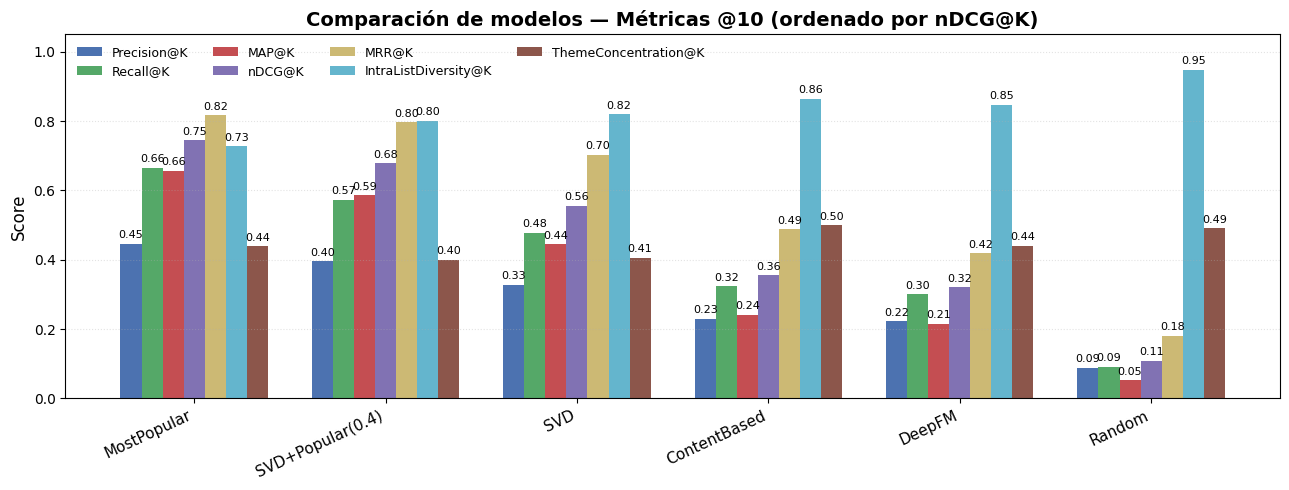

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Resultados
results = {
    "MostPopular":      metrics_pop,
    "Random":           metrics_rand,
    "ContentBased":     metrics_cb,
    "SVD":              metrics_svd,
    "SVD+Popular(0.4)": metrics_hybrid,
    "DeepFM":           metrics_deepfm,
}

metric_cols = [
    "Precision@K",
    "Recall@K",
    "MAP@K",
    "nDCG@K",
    "MRR@K",
    "IntraListDiversity@K",
    "ThemeConcentration@K",
]

# ordenar por esta métrica
metric_to_sort = "nDCG@K"

df_res = pd.DataFrame(results).T.reindex(columns=metric_cols)

df_res = df_res.sort_values(by=metric_to_sort, ascending=False)

colors = [
    "#4C72B0",  # Precision
    "#55A868",  # Recall
    "#C44E52",  # MAP
    "#8172B3",  # nDCG
    "#CCB974",  # MRR
    "#64B5CD",  # ILD
    "#8C564B",  # ThemeConc
]

plt.figure(figsize=(13,5))
x = np.arange(len(df_res))
w = 0.11

for j, (m, c) in enumerate(zip(metric_cols, colors)):
    vals = df_res[m].values
    plt.bar(x + j*w, vals, width=w, label=m, color=c)
    for i, v in enumerate(vals):
        if pd.isna(v): 
            continue
        plt.text(x[i] + j*w, v + 0.01, f"{v:.2f}",
                 ha="center", va="bottom", fontsize=8)

plt.xticks(x + w*3, df_res.index, rotation=25, ha="right", fontsize=11)
plt.ylim(0, 1.05)
plt.ylabel("Score", fontsize=12)
plt.title(
    f"Comparación de modelos — Métricas @10 (ordenado por {metric_to_sort})",
    fontsize=14, weight="bold"
)
plt.grid(axis="y", linestyle=":", alpha=0.35)
plt.legend(ncol=4, fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig("figs/metricas/metrics_at_k_sorted.png", dpi=300)
plt.show()

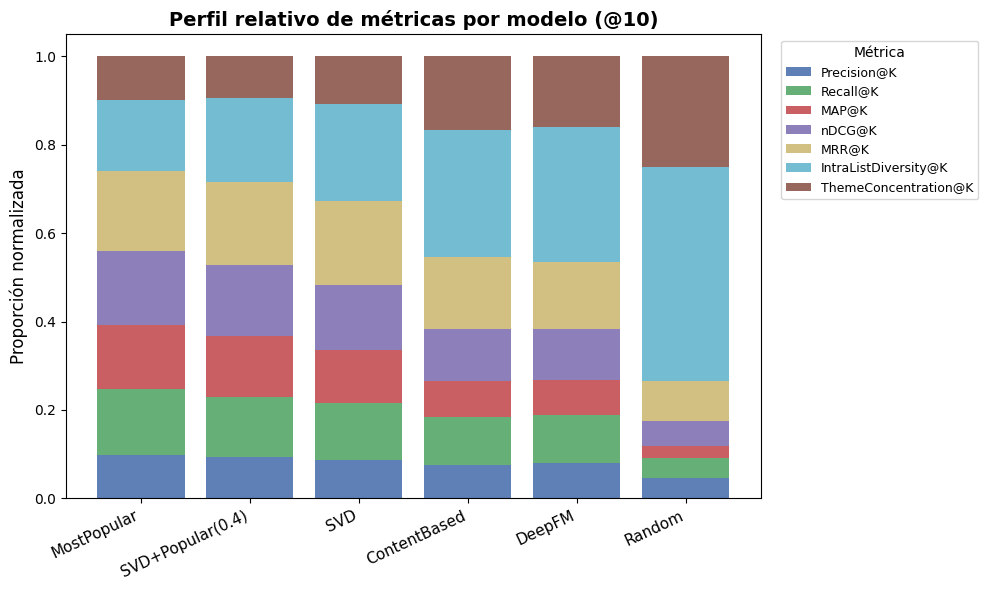

In [75]:
metrics_for_stack = [
    "Precision@K",
    "Recall@K",
    "MAP@K",
    "nDCG@K",
    "MRR@K",
    "IntraListDiversity@K",
    "ThemeConcentration@K",
]

stack_df = df_res[metrics_for_stack].copy()
stack_df = stack_df.fillna(0.0)

data = stack_df.values
data_norm = data / data.sum(axis=1, keepdims=True)

models = stack_df.index.tolist()

colors_stack = [
    "#4C72B0",  # Precision
    "#55A868",  # Recall
    "#C44E52",  # MAP
    "#8172B3",  # nDCG
    "#CCB974",  # MRR
    "#64B5CD",  # ILD
    "#8C564B",  # ThemeConc
]

plt.figure(figsize=(10,6))
bottom = np.zeros(len(models))

for j, (metric, col) in enumerate(zip(metrics_for_stack, colors_stack)):
    vals = data_norm[:, j]
    plt.bar(models, vals, bottom=bottom, color=col, label=metric, alpha=0.9)
    bottom += vals

plt.xticks(rotation=25, ha="right", fontsize=11)
plt.ylabel("Proporción normalizada", fontsize=12)
plt.title("Perfil relativo de métricas por modelo (@10)", fontsize=14, weight="bold")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=9, title="Métrica")
plt.tight_layout()
plt.savefig("figs/metricas/stacked_metrics_models.png", dpi=300)
plt.show()


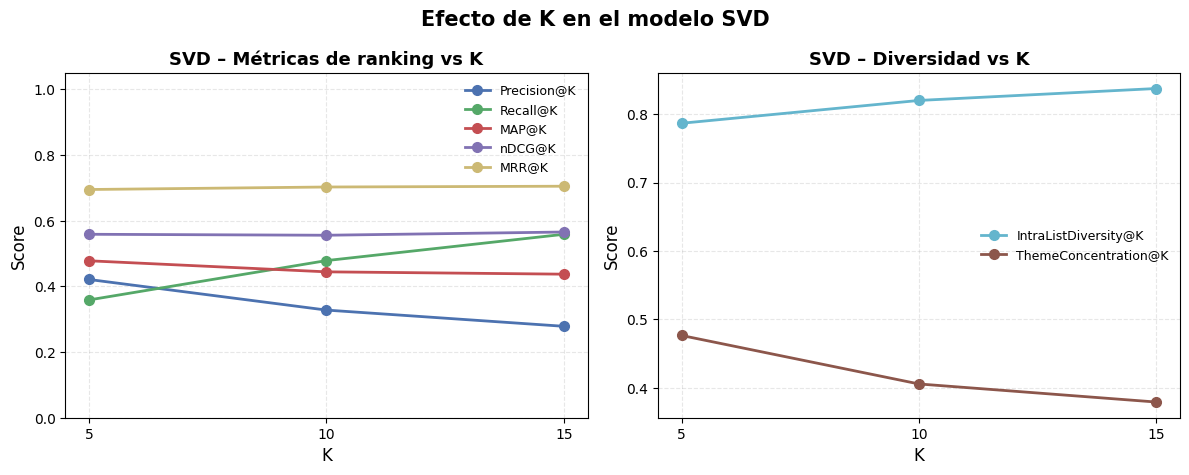

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas SVD para distintos K
metrics_svd_by_k = {
    5:  metrics_svd_k5,
    10: metrics_svd,
    15: metrics_svd_k15,
}

Ks = sorted(metrics_svd_by_k.keys())

color_map = {
    "Precision@K":          "#4C72B0",  # azul
    "Recall@K":             "#55A868",  # verde
    "MAP@K":                "#C44E52",  # rojo
    "nDCG@K":               "#8172B3",  # morado
    "MRR@K":                "#CCB974",  # amarillo
    "IntraListDiversity@K": "#64B5CD",  # celeste
    "ThemeConcentration@K": "#8C564B",  # café
}

ranking_metrics   = ["Precision@K", "Recall@K", "MAP@K", "nDCG@K", "MRR@K"]
diversity_metrics = ["IntraListDiversity@K", "ThemeConcentration@K"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharex=True)

ax = axes[0]

for m in ranking_metrics:
    vals = [metrics_svd_by_k[k].get(m, np.nan) for k in Ks]
    if all(np.isnan(vals)):
        continue
    ax.plot(
        Ks, vals,
        marker="o",
        linewidth=2,
        markersize=7,
        color=color_map[m],
        label=m
    )

ax.set_xlabel("K", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("SVD – Métricas de ranking vs K", fontsize=13, weight="bold")
ax.grid(alpha=0.3, linestyle="--")
ax.set_xticks(Ks)
ax.set_ylim(0, 1.05)

ax.legend(fontsize=9, frameon=False)

ax2 = axes[1]

for m in diversity_metrics:
    vals = [metrics_svd_by_k[k].get(m, np.nan) for k in Ks]
    if all(np.isnan(vals)):
        continue
    ax2.plot(
        Ks, vals,
        marker="o",
        linewidth=2,
        markersize=7,
        color=color_map[m],
        label=m
    )

ax2.set_xlabel("K", fontsize=12)
ax2.set_ylabel("Score", fontsize=12)
ax2.set_title("SVD – Diversidad vs K", fontsize=13, weight="bold")
ax2.grid(alpha=0.3, linestyle="--")
ax2.set_xticks(Ks)

ax2.legend(fontsize=9, frameon=False)

plt.suptitle("Efecto de K en el modelo SVD", fontsize=15, weight="bold")
plt.tight_layout()
plt.savefig("figs/metricas/svd_vs_k.png", dpi=300, bbox_inches="tight")
plt.show()


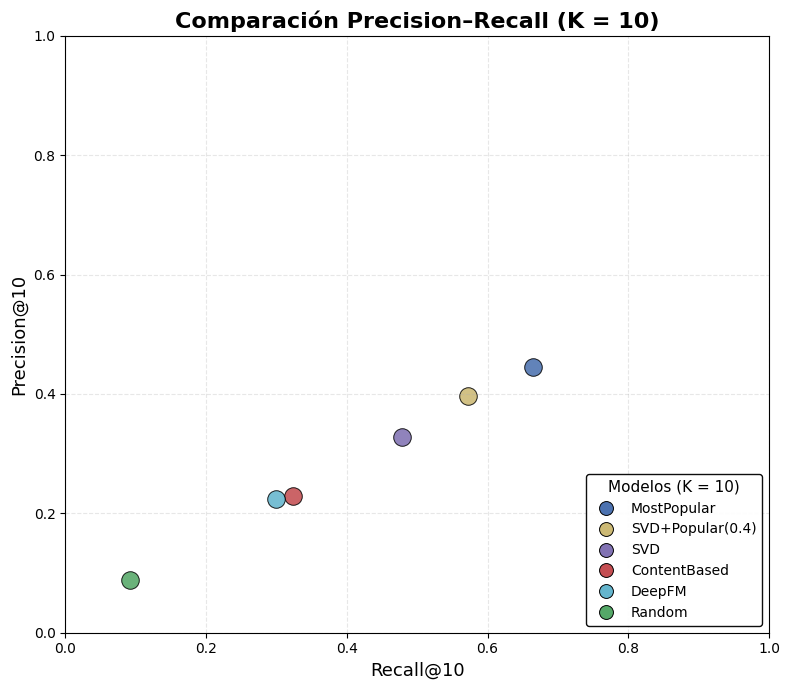

In [78]:
models = df_res.index.tolist()
prec = df_res["Precision@K"].values
rec  = df_res["Recall@K"].values

colors = {
    "MostPopular":      "#4C72B0",
    "Random":           "#55A868",
    "ContentBased":     "#C44E52",
    "SVD":              "#8172B3",
    "SVD+Popular(0.4)": "#CCB974",
    "DeepFM":           "#64B5CD",
}

plt.figure(figsize=(8,7))

for m in models:
    plt.scatter(
        rec[m == np.array(models)][0],
        prec[m == np.array(models)][0],
        s=160,
        color=colors[m],
        edgecolor="black",
        linewidth=0.7,
        alpha=0.88
    )

plt.xlabel("Recall@10", fontsize=13)
plt.ylabel("Precision@10", fontsize=13)
plt.title("Comparación Precision–Recall (K = 10)", fontsize=16, weight="bold")

plt.grid(alpha=0.3, linestyle="--")
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)

legend_elements = []
for m in models:
    legend_elements.append(
        plt.Line2D(
            [0], [0],
            marker="o", color=colors[m],
            markersize=10, linestyle="",
            markeredgecolor="black", markeredgewidth=0.7,
            label=m
        )
    )

legend = plt.legend(
    handles=legend_elements,
    title="Modelos (K = 10)",
    fontsize=10,
    title_fontsize=11,
    loc="lower right",
    frameon=True,
    facecolor="white",
    edgecolor="black",
)

legend.get_frame().set_alpha(0.95)

plt.tight_layout()
plt.savefig("figs/metricas/precision_recall_scatter_box_legend.png", dpi=300)
plt.show()

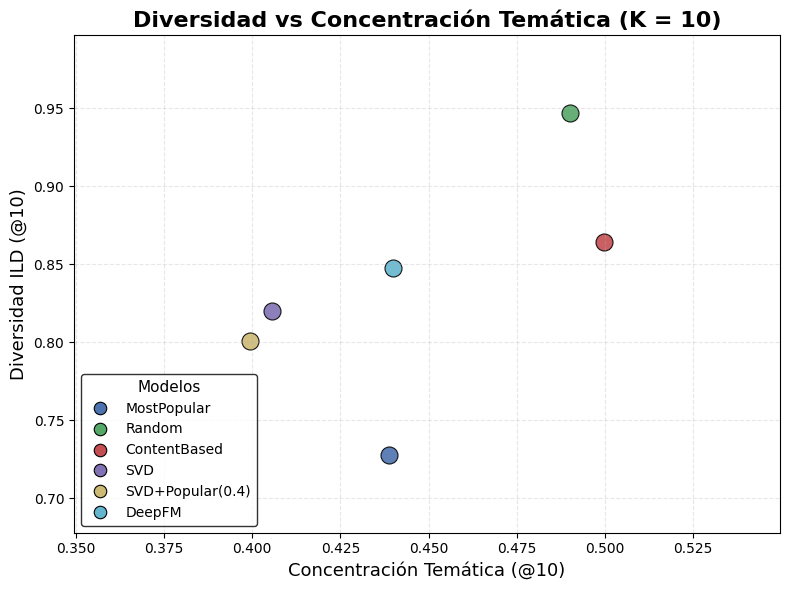

In [77]:
import matplotlib.pyplot as plt

models = list(results.keys())

ild_vals   = [results[m].get("IntraListDiversity@K", 0) for m in models]
conc_vals  = [results[m].get("ThemeConcentration@K", 0) for m in models]

colors = {
    "MostPopular":      "#4C72B0",
    "Random":           "#55A868",
    "ContentBased":     "#C44E52",
    "SVD":              "#8172B3",
    "SVD+Popular(0.4)": "#CCB974",
    "DeepFM":           "#64B5CD",
}

plt.figure(figsize=(8,6))

for m in models:
    plt.scatter(
        conc_vals[models.index(m)],
        ild_vals[models.index(m)],
        s=150,
        color=colors[m],
        edgecolor="black",
        linewidth=0.8,
        alpha=0.9
    )

plt.xlabel("Concentración Temática (@10)", fontsize=13)
plt.ylabel("Diversidad ILD (@10)", fontsize=13)
plt.title("Diversidad vs Concentración Temática (K = 10)", fontsize=16, weight="bold")

plt.grid(alpha=0.3, linestyle="--")

plt.xlim(
    max(0, min(conc_vals) - 0.05),
    min(1, max(conc_vals) + 0.05)
)
plt.ylim(
    max(0, min(ild_vals) - 0.05),
    min(1, max(ild_vals) + 0.05)
)

legend_elements = [
    plt.Line2D([0], [0], marker="o", linestyle="", color=colors[m],
               label=m, markersize=9,
               markeredgecolor="black", markeredgewidth=0.8)
    for m in models
]

plt.legend(
    handles=legend_elements,
    title="Modelos",
    fontsize=10,
    title_fontsize=11,
    loc="lower left",
    frameon=True,
    facecolor="white",
    edgecolor="black"
)

plt.tight_layout()
plt.savefig("figs/metricas/diversity_scatter_ranges.png", dpi=300)
plt.show()


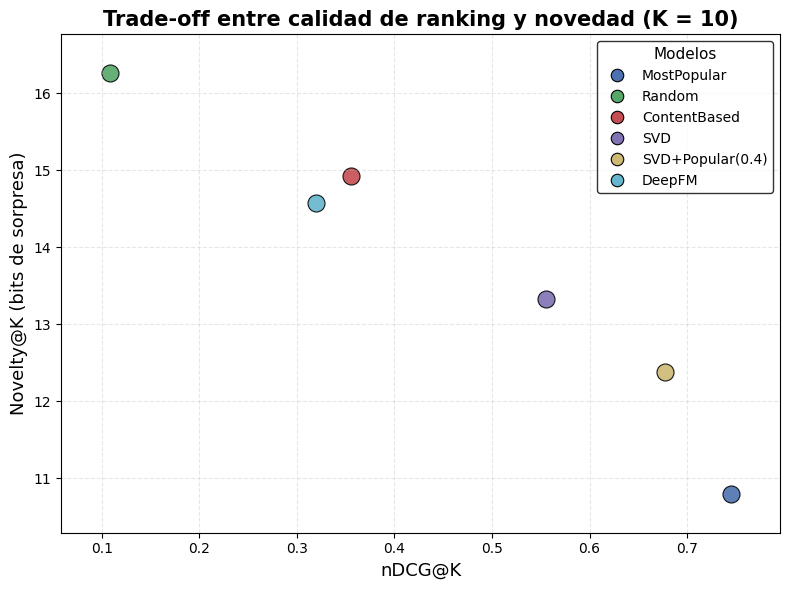

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())

ndcg_vals = [results[m].get("nDCG@K", np.nan) for m in models]
nov_vals  = [results[m].get("Novelty@K", np.nan) for m in models]

model_colors = {
    "MostPopular":      "#4C72B0",
    "Random":           "#55A868",
    "ContentBased":     "#C44E52",
    "SVD":              "#8172B3",
    "SVD+Popular(0.4)": "#CCB974",
    "DeepFM":           "#64B5CD",
}

plt.figure(figsize=(8,6))

for m in models:
    x = results[m].get("nDCG@K", np.nan)
    y = results[m].get("Novelty@K", np.nan)
    plt.scatter(
        x, y,
        s=150,
        color=model_colors[m],
        edgecolor="black",
        linewidth=0.8,
        alpha=0.9
    )

plt.xlabel("nDCG@K", fontsize=13)
plt.ylabel("Novelty@K (bits de sorpresa)", fontsize=13)
plt.title("Trade-off entre calidad de ranking y novedad (K = 10)", fontsize=15, weight="bold")
plt.grid(alpha=0.3, linestyle="--")

plt.xlim(
    max(0, min(ndcg_vals) - 0.05),
    min(1, max(ndcg_vals) + 0.05)
)
plt.ylim(
    max(0, min(nov_vals) - 0.5),
    max(nov_vals) + 0.5
)

legend_elems = [
    plt.Line2D(
        [0],[0],
        marker="o", linestyle="",
        color=model_colors[m],
        markeredgecolor="black", markeredgewidth=0.8,
        markersize=9, label=m
    )
    for m in models
]

plt.legend(
    handles=legend_elems,
    title="Modelos",
    fontsize=10,
    title_fontsize=11,
    loc="upper right",
    frameon=True,
    facecolor="white",
    edgecolor="black"
)

plt.tight_layout()
plt.savefig("figs/metricas/ndcg_vs_novelty.png", dpi=300, bbox_inches="tight")
plt.show()

## 4.2 Visualización de Espacios Latentes

c:\Users\cobal\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


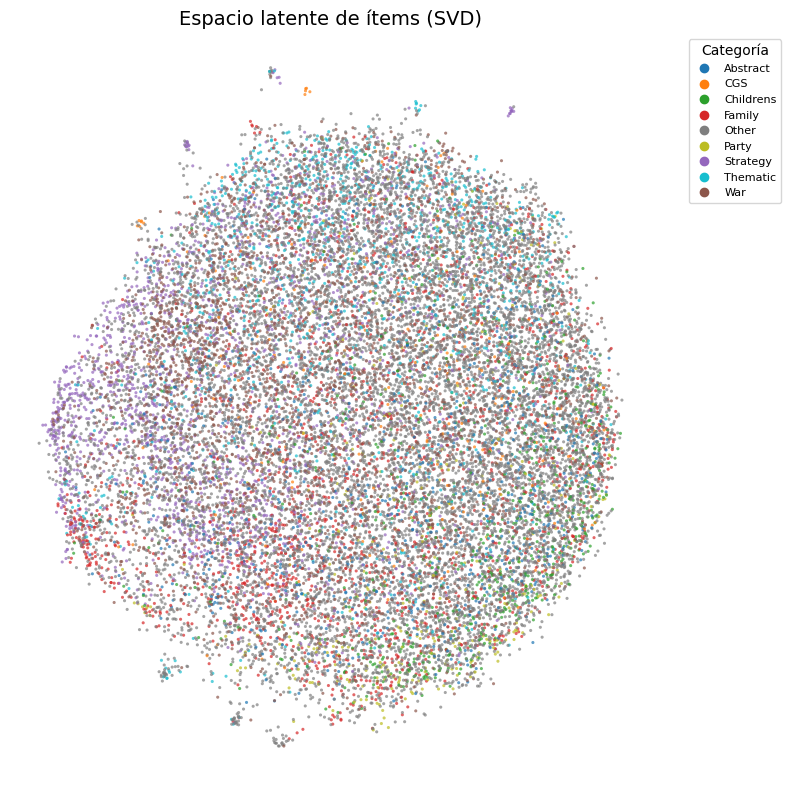

c:\Users\cobal\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


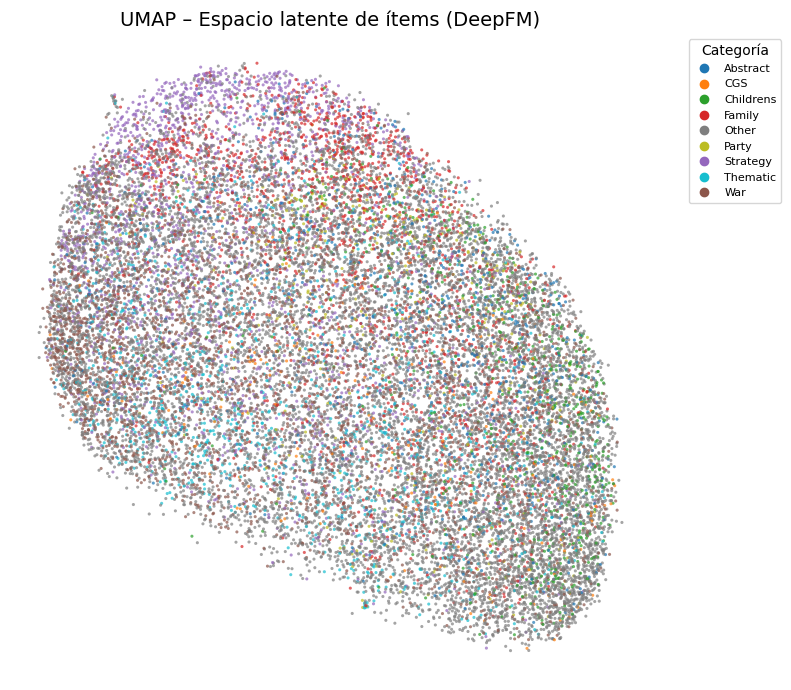

In [51]:
import umap
from surprise import SVD

# --- Categorías por juego ---
cat_cols = [c for c in df_games.columns if c.startswith("Cat:")]

if "tags_list" not in df_games.columns:
    def row_to_tags(row):
        tags = []
        for c in cat_cols:
            try:
                if int(row[c]) == 1:
                    tags.append(c.replace("Cat:", ""))
            except Exception:
                continue
        return tags
    df_games["tags_list"] = df_games.apply(row_to_tags, axis=1)

item_to_tags = df_games.set_index("BGGId")["tags_list"].to_dict()

# --- Colores fijos por categoría ---
category_colors = {
    "Abstract":  "#1f77b4",
    "CGS":       "#ff7f0e",
    "Childrens": "#2ca02c",
    "Family":    "#d62728",
    "Party":     "#bcbd22",
    "Strategy":  "#9467bd",
    "Thematic":  "#17becf",
    "War":       "#8c564b",
    "Other":     "#7f7f7f",
}

# 1) UMAP SVD
svd_vis = SVD(n_factors=50, n_epochs=20, random_state=42).fit(trainset)

item_inner_ids = list(trainset.all_items())
item_emb_svd = svd_vis.qi[item_inner_ids]
raw_iids_svd = [trainset.to_raw_iid(i) for i in item_inner_ids]

cats_svd = []
for iid in raw_iids_svd:
    tags = item_to_tags.get(str(iid), [])
    cats_svd.append(tags[0] if tags else "Other")

colors_svd = [category_colors.get(cat, "#7f7f7f") for cat in cats_svd]

reducer_svd = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
Z_svd = reducer_svd.fit_transform(item_emb_svd)

plt.figure(figsize=(8,8))
plt.scatter(
    Z_svd[:,0], Z_svd[:,1],
    c=colors_svd,
    s=5,
    alpha=0.7,
    linewidths=0
)
plt.title("Espacio latente de ítems (SVD)", fontsize=14)
plt.axis("off")

present_cats_svd = sorted(set(cats_svd))
handles_svd = [
    plt.Line2D([], [], marker="o", linestyle="", color=category_colors[c],
               label=c, markersize=6)
    for c in present_cats_svd
]
plt.legend(handles=handles_svd, bbox_to_anchor=(1.05,1), loc="upper left",
           fontsize=8, title="Categoría")

plt.tight_layout()
plt.savefig("figs/latent_svd_umap_fixed_colors.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) UMAP DeepFM
item_emb_dfm = deepfm_state["model"].item_emb.weight.detach().cpu().numpy()
item_ids_dfm = list(deepfm_state["iid2idx"].keys())

cats_dfm = []
for iid in item_ids_dfm:
    tags = item_to_tags.get(str(iid), [])
    cats_dfm.append(tags[0] if tags else "Other")

colors_dfm = [category_colors.get(cat, "#7f7f7f") for cat in cats_dfm]

reducer_dfm = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
Z_dfm = reducer_dfm.fit_transform(item_emb_dfm)

plt.figure(figsize=(8,7))
plt.scatter(
    Z_dfm[:,0], Z_dfm[:,1],
    c=colors_dfm,
    s=5,
    alpha=0.7,
    linewidths=0
)
plt.title("UMAP – Espacio latente de ítems (DeepFM)", fontsize=14)
plt.axis("off")

present_cats_dfm = sorted(set(cats_dfm))
handles_dfm = [
    plt.Line2D([], [], marker="o", linestyle="", color=category_colors[c],
               label=c, markersize=6)
    for c in present_cats_dfm
]
plt.legend(handles=handles_dfm, bbox_to_anchor=(1.05,1), loc="upper left",
           fontsize=8, title="Categoría")

plt.tight_layout()
plt.savefig("figs/metricas/deepfm_umap_items_fixed_colors.png", dpi=300, bbox_inches="tight")
plt.show()


# 5. Mejoras en modelos vía Embeddings

Construiremos una matriz única de características (un "embedding" de contenido) para cada ítem (juego) en nuestro dataset. Esta matriz combinará características numéricas (de df_games) y características categóricas/binarias (de los otros CSVs). Esta matriz será la entrada de "contenido" para nuestro modelo híbrido.

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

print("Definiendo funciones para construir la matriz de features de ítem...")

def build_item_feature_matrix(idx2iid, df_games, df_mechanics, df_themes, df_subcategories, df_designers, df_artists, df_publishers):
    """
    Construye una matriz de features de ítem única alineada con el idx2iid del trainset.
    """
    print("Construyendo matriz de features de ítem...")
    n_items = len(idx2iid)
    all_bggids = [idx2iid[i] for i in range(n_items)]
    
    num_cols = ['GameWeight', 'YearPublished', 'MinPlayers', 'MaxPlayers', 'ComMinPlaytime', 'ComMaxPlaytime']
    
    games_num = df_games.set_index('BGGId').reindex(all_bggids)[num_cols].fillna(0).values
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(games_num)
    print(f"  > Features numéricas escaladas: {features_scaled.shape}")

    
    def get_binary_features(df, bggids):
        if 'BGGId' in df.columns:
            df = df.set_index('BGGId')
        return df.reindex(bggids).fillna(0).values

    mech_bin = get_binary_features(df_mechanics, all_bggids)
    print(f"  > Features de mecánicas: {mech_bin.shape}")
    
    themes_bin = get_binary_features(df_themes, all_bggids)
    print(f"  > Features de temas: {themes_bin.shape}")
    
    subcat_bin = get_binary_features(df_subcategories, all_bggids)
    print(f"  > Features de subcategorías: {subcat_bin.shape}")
    
    designers_bin = get_binary_features(df_designers, all_bggids)
    print(f"  > Features de diseñadores: {designers_bin.shape}")
    
    artists_bin = get_binary_features(df_artists, all_bggids)
    print(f"  > Features de artistas: {artists_bin.shape}")
    
    publishers_bin = get_binary_features(df_publishers, all_bggids)
    print(f"  > Features de publishers: {publishers_bin.shape}")

    all_features = np.concatenate([
        features_scaled,
        mech_bin,
        themes_bin,
        subcat_bin,
        designers_bin,
        artists_bin,
        publishers_bin
    ], axis=1)
    
    print(f"Matriz de features creada con shape: {all_features.shape}")
    
    return torch.tensor(all_features, dtype=torch.float)

print("Funciones de features listas.")

In [ ]:
def fm_bi_interaction(feat_embs):
    # feat_embs: [B, F, D] (Batch, N_Features, Dim_Embed)
    sum_feat_embs = feat_embs.sum(dim=1)  # [B, D]
    sum_sq = sum_feat_embs * sum_feat_embs # [B, D]
    
    sq_sum = (feat_embs * feat_embs).sum(dim=1) # [B, D]
    
    bi = 0.5 * (sum_sq - sq_sum).sum(dim=1, keepdim=True) # [B, 1]
    return bi

class DeepFMHybrid(nn.Module):
    def __init__(self, n_users, n_items, n_item_features, emb_dim=32, mlp_layers=(128, 64), dropout=0.2, rating_scale=(1, 10)):
        super().__init__()
        
        self.rmin, self.rmax = rating_scale
        self.span = self.rmax - self.rmin
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim) # Embedding Latente (CF)
        
        self.item_feat_linear = nn.Linear(n_item_features, emb_dim) # Proyección de Features (CB)
        self.item_feat_dropout = nn.Dropout(dropout)
        
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        
        deep_in_dim = emb_dim * 2 # user_emb + item_emb
        layers = []
        prev = deep_in_dim
        for h in mlp_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.deep = nn.Sequential(*layers)
        
        self._init_params()

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def fm_bi_interaction(self, feat_embs):
        sum_feat_embs = feat_embs.sum(dim=1)
        sum_sq = sum_feat_embs * sum_feat_embs
        sq_sum = (feat_embs * feat_embs).sum(dim=1)
        bi = 0.5 * (sum_sq - sq_sum).sum(dim=1, keepdim=True)
        return bi

    def forward(self, u, i, i_feats):
        # u: (B)
        # i: (B)
        # i_feats: (B, N_item_features)
        
        ue = self.user_emb(u) # (B, D)
        
        ie_collab = self.item_emb(i) # (B, D)
        
        ie_content = F.relu(self.item_feat_linear(i_feats)) # (B, D)
        ie_content = self.item_feat_dropout(ie_content)
        
        ie = (ie_collab + ie_content) / 2.0 # (B, D)

        lin = self.global_bias + self.user_bias(u) + self.item_bias(i) # (B, 1)

        feats = torch.stack([ue, ie], dim=1) # (B, 2, D)
        fm = self.fm_bi_interaction(feats) # (B, 1)
        
        deep_in = torch.cat([ue, ie], dim=1) # (B, D*2)
        deep_out = self.deep(deep_in) # (B, 1)
        
        y = lin + fm + deep_out
        
        # Escalamos a (rmin, rmax)
        y = torch.sigmoid(y.squeeze()) * self.span + self.rmin
        
        return y.squeeze()

print("Modelo DeepFMHybrid definido.")

In [ ]:
class DeepFMHybridDataset(Dataset):
    def __init__(self, df, uid2idx, iid2idx, item_features_matrix,
                 user_col="Username", item_col="BGGId", rating_col="Rating"):
        
        self.item_features_matrix = item_features_matrix
        
        df_clean = df.copy()
        df_clean[user_col] = df_clean[user_col].astype(str)
        df_clean[item_col] = df_clean[item_col].astype(str)
        
        mask_valid = (
            df_clean[user_col].notna() & 
            df_clean[item_col].notna() &
            df_clean[user_col].isin(uid2idx.keys()) &
            df_clean[item_col].isin(iid2idx.keys())
        )
        df_clean = df_clean[mask_valid].reset_index(drop=True)
        
        if len(df_clean) < len(df):
            print(f"[DeepFMHybridDataset] Filtrando {len(df) - len(df_clean)} filas inválidas de {len(df)} totales")
        
        self.uval = df_clean[user_col].map(uid2idx).values.astype(np.int64)
        self.ival = df_clean[item_col].map(iid2idx).values.astype(np.int64)
        
        self.yval = df_clean[rating_col].values.astype(np.float32)

    def __len__(self):
        return len(self.yval)

    def __getitem__(self, idx):
        u_idx = self.uval[idx]
        i_idx = self.ival[idx]
        
        i_feat = self.item_features_matrix[i_idx]
        
        y = self.yval[idx]
        
        return u_idx, i_idx, i_feat, y

print("Dataset Híbrido definido.")

def train_deepfm_hybrid(
    train_df,
    item_features_matrix,
    rating_scale=(1, 10),
    user_col="Username",
    item_col="BGGId",
    rating_col="Rating",
    emb_dim=32,
    mlp_layers=(128, 64),
    dropout=0.2,
    lr=2e-3,
    weight_decay=1e-6,
    batch_size=2048,
    epochs=8,
    seed=42,
    device=None,
    log_every=200
):
    print("[DeepFM-Hybrid] Preparando datos y modelo...")
    t0 = time.time()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    uid2idx, iid2idx, idx2uid, idx2iid = build_id_mappings_from_traindf(train_df, user_col, item_col)
    
    ds = DeepFMHybridDataset(train_df, uid2idx, iid2idx, item_features_matrix, user_col, item_col, rating_col)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    item_features_matrix = item_features_matrix.to(device)

    model = DeepFMHybrid(
        n_users=len(uid2idx),
        n_items=len(iid2idx),
        n_item_features=item_features_matrix.shape[1],
        emb_dim=emb_dim,
        mlp_layers=mlp_layers,
        dropout=dropout,
        rating_scale=rating_scale
    ).to(device)
    
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    
    print(f"[DeepFM-Hybrid] Entrenando en {device} (epochs={epochs}, bs={batch_size})...")
    
    for ep in range(1, epochs + 1):
        model.train()
        ep_loss, n, step = 0.0, 0, 0
        ep_t0 = time.time()
        
        for (u, i, i_feat, y) in dl:
            u, i, i_feat, y = u.to(device), i.to(device), i_feat.to(device), y.to(device)
            
            opt.zero_grad()
            pred = model(u, i, i_feat)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            ep_loss += loss.item() * y.size(0)
            n += y.size(0)
            step += 1
            
            if step % log_every == 0:
                print(f"[DeepFM-Hybrid] [ep:{ep}] step:{step} | loss={(ep_loss/n):.4f}")
        
        print(f"[DeepFM-Hybrid] Epoch {ep}/{epochs} | loss={(ep_loss/n):.4f} | tiempo={_fmt_secs(time.time()-ep_t0)}")

    print(f"[DeepFM-Hybrid] Listo en {_fmt_secs(time.time()-t0)}")
    
    state = {
        "model": model.eval(),
        "uid2idx": uid2idx,
        "idx2uid": idx2uid,
        "iid2idx": iid2idx,
        "idx2iid": idx2iid,
        "device": device,
        "rating_scale": rating_scale,
        "item_features_matrix": item_features_matrix
    }
    return state

print("Loop de entrenamiento Híbrido definido.")

@torch.no_grad()
def deepfm_hybrid_topn_from_candidates(state, cands_by_u, n=10, log_every=10000):
    print(f"[DeepFM-Hybrid] Prediciendo sobre candidatos...")
    t0 = time.time()
    
    model = state["model"].eval()
    uid2idx = state["uid2idx"]
    iid2idx = state["iid2idx"]
    device = state["device"]
    item_features_matrix = state["item_features_matrix"]
    
    preds = []
    users = list(cands_by_u.keys())
    total_u = len(users)

    batch_u_idx, batch_i_idx = [], []
    batch_uid, batch_iid = [], []

    def flush():
        nonlocal preds, batch_u_idx, batch_i_idx, batch_uid, batch_iid
        if not batch_u_idx:
            return
        
        u_tensor = torch.tensor(batch_u_idx, dtype=torch.long, device=device)
        i_tensor = torch.tensor(batch_i_idx, dtype=torch.long, device=device)
        
        i_feat_tensor = item_features_matrix[i_tensor]
        
        est = model(u_tensor, i_tensor, i_feat_tensor).cpu().numpy().tolist()
        
        for uid, iid, est_val in zip(batch_uid, batch_iid, est):
            preds.append((uid, iid, None, float(est_val), {}))
            
        batch_u_idx.clear(); batch_i_idx.clear(); batch_uid.clear(); batch_iid.clear()

    for idx, uid in enumerate(users, 1):
        uidx = uid2idx.get(str(uid), None)
        if uidx is None:
            continue
            
        if idx % log_every == 0:
            print(f"[DeepFM-Hybrid] Predicción: {idx}/{total_u} ({idx/total_u:.1%}) | ETA {_eta(t0, idx, total_u)}")

        for iid in cands_by_u[uid]:
            iidx = iid2idx.get(str(iid), None)
            if iidx is None:
                continue
                
            batch_u_idx.append(uidx)
            batch_i_idx.append(iidx)
            batch_uid.append(uid)
            batch_iid.append(iid)
            
            if len(batch_u_idx) >= 65_536:
                flush()
    flush()
    
    print(f"[DeepFM-Hybrid] Predicción: {_fmt_secs(time.time()-t0)}")
    
    t1 = time.time()
    topn = topn_from_predictions(preds, n=n)
    print(f"[DeepFM-Hybrid] Top-N: {_fmt_secs(time.time()-t1)}")
    return topn

print("Loop de predicción Híbrido definido.")

In [ ]:
print("Generando mapeos para la matriz de features...")
_, _, _, idx2iid_full = build_id_mappings_from_traindf(train_df, "Username", "BGGId")

item_features_matrix = build_item_feature_matrix(
    idx2iid_full, 
    df_games, 
    df_mechanics, 
    df_themes, 
    df_subcategories, 
    df_designers_reduced, 
    df_artists_reduced, 
    df_publishers_reduced
)

deepfm_hybrid_state = train_deepfm_hybrid(
    train_df,
    item_features_matrix,
    rating_scale=(1, 10),
    emb_dim=32,
    mlp_layers=(128, 64),
    dropout=0.2,
    lr=2e-3,
    weight_decay=1e-6,
    batch_size=9216,
    epochs=8,
    seed=42
)

topn_deepfm_hybrid = deepfm_hybrid_topn_from_candidates(
    deepfm_hybrid_state, 
    cands, 
    n=10
)

metrics_deepfm_hybrid = precision_recall_ndcg_map_mrr_at_k(
    topn_deepfm_hybrid, 
    heldout, 
    k=10,
    item_to_tags=item_to_tags,
    item_popularity=item_popularity,
    total_interacciones_train=total_interacciones_train,
    save_dir="metrics",
    save_name="deepfm_embedding_model"
)